## Data Preprocessing

**Functions:**
- Data loading and quality control
- Normalization and highly variable gene selection  
- PCA dimensionality reduction

**Outputs:**
- `figures/qc_metrics.png`
- `figures/highly_variable_genes_hvg.png`
- `figures/pca_variance_ratio_pca_variance.png`
- `results/preprocessed_data.h5ad`

In [1]:
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import time
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import dca
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import ranksums

# Set warnings and plotting parameters (OpenProblems style)
warnings.filterwarnings("ignore")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
    'savefig.transparent': False
})

# Set Scanpy parameters
sc.settings.verbosity = 3

print("Data Preprocessing and Quality Control")


Data Preprocessing and Quality Control



1.1 Data Loading
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

1.2 Quality Control and Filtering
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePh


1.1 Data Loading
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

1.2 Quality Control and Filtering
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePh

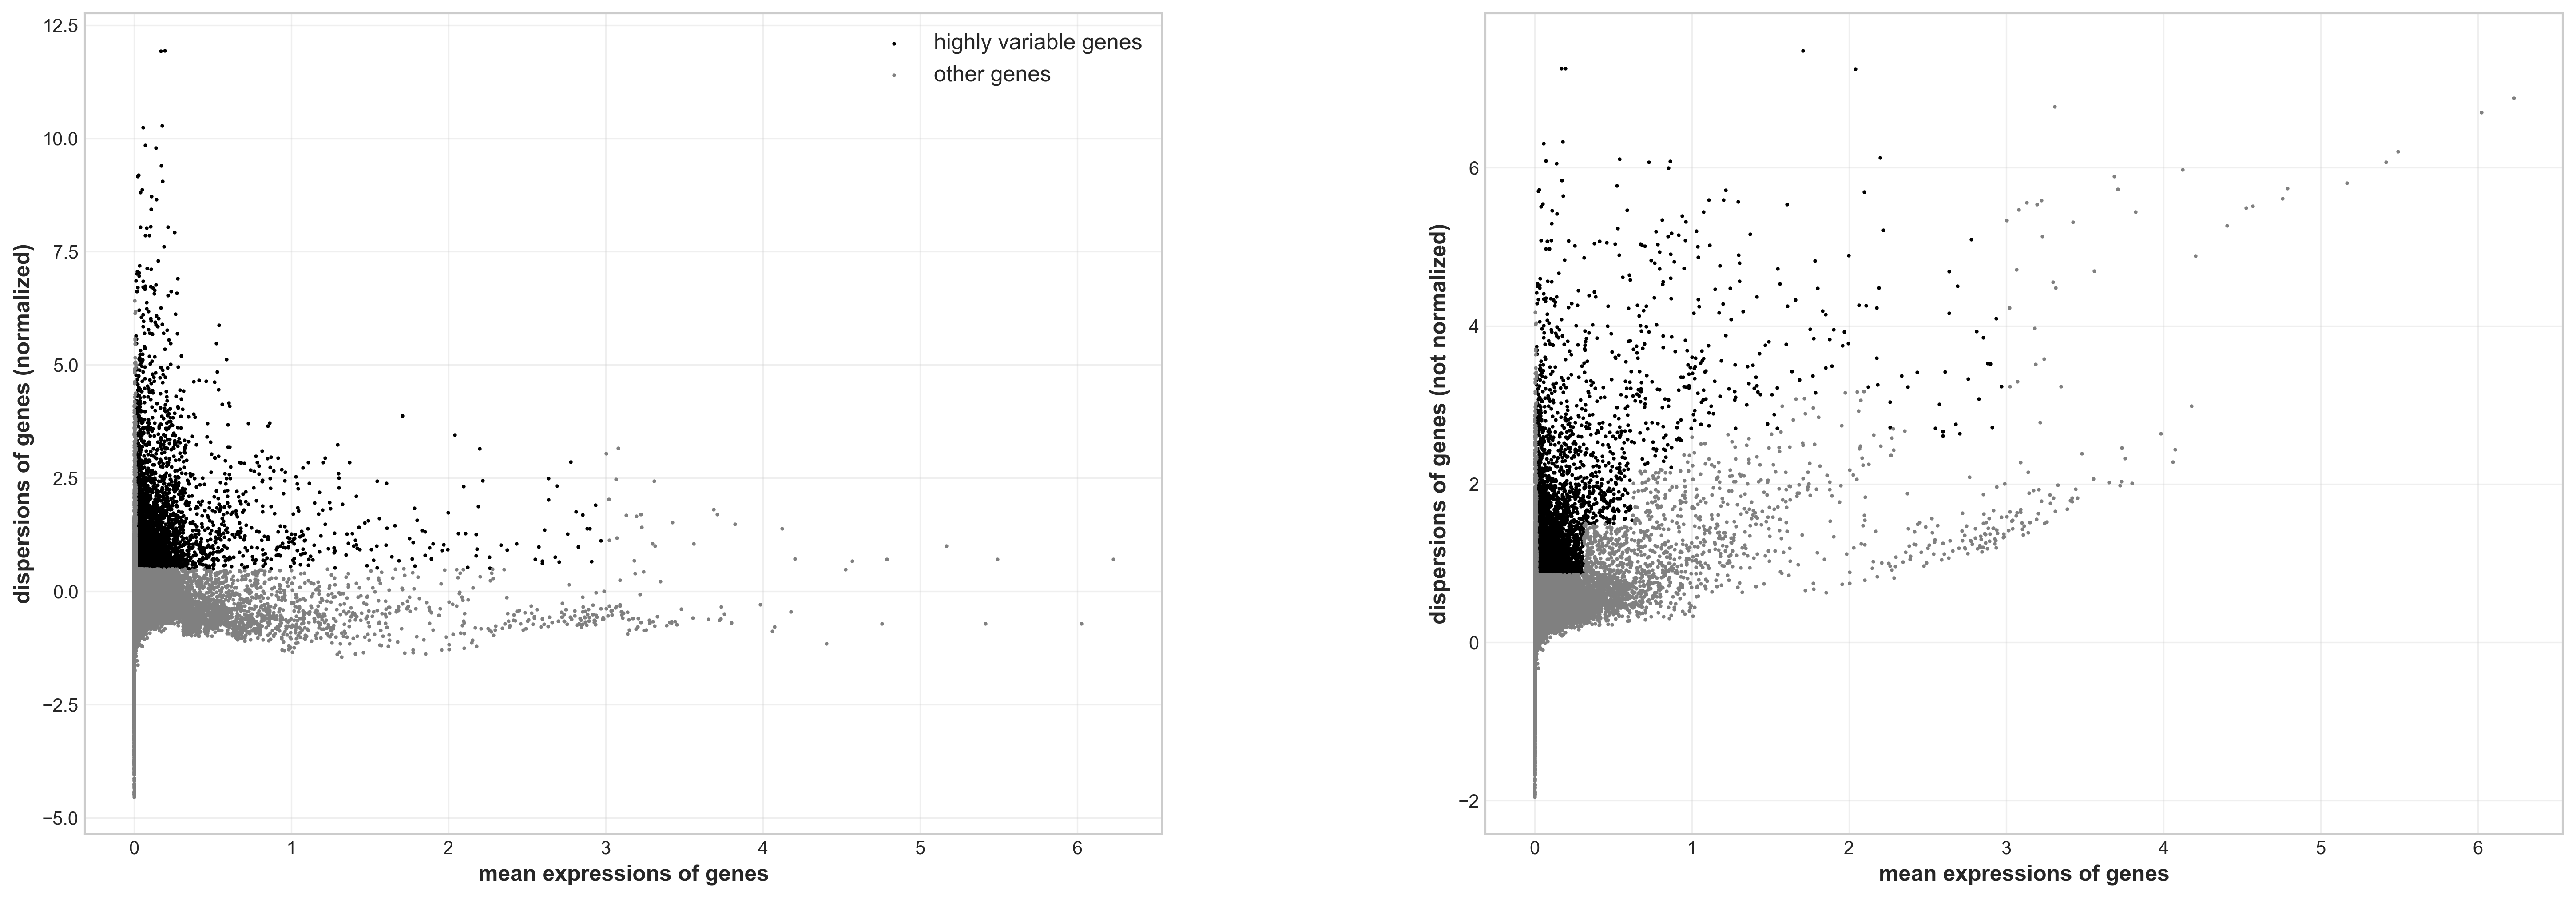


1.1 Data Loading
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

1.2 Quality Control and Filtering
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePh

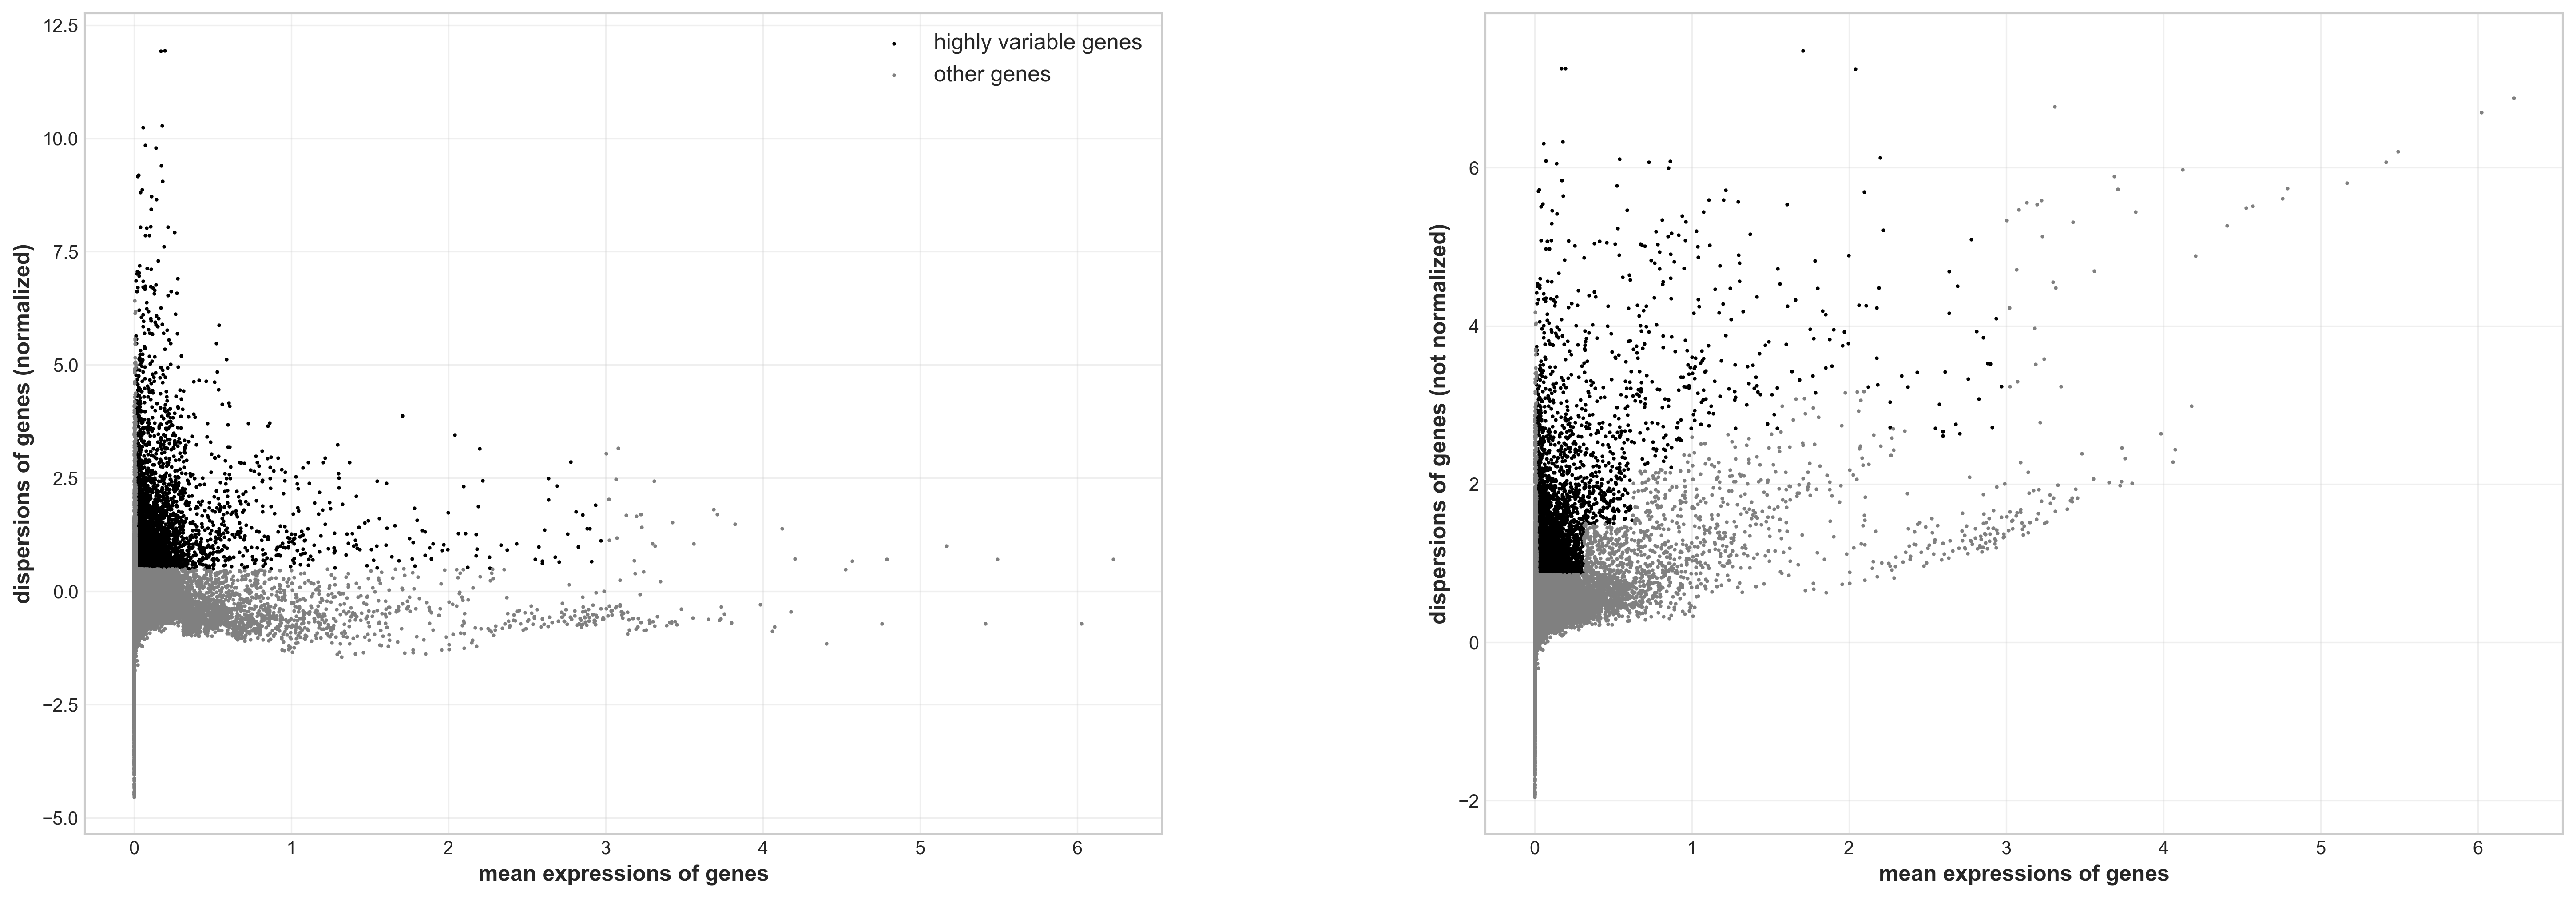

Number of highly variable genes: 3696
Total genes: 31535
Filtered data shape: (13199, 3696)

1.4 Scaling and Principal Component Analysis
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
    finished (0:00:01)
    finished (0:00:01)



1.1 Data Loading
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

1.2 Quality Control and Filtering
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePh

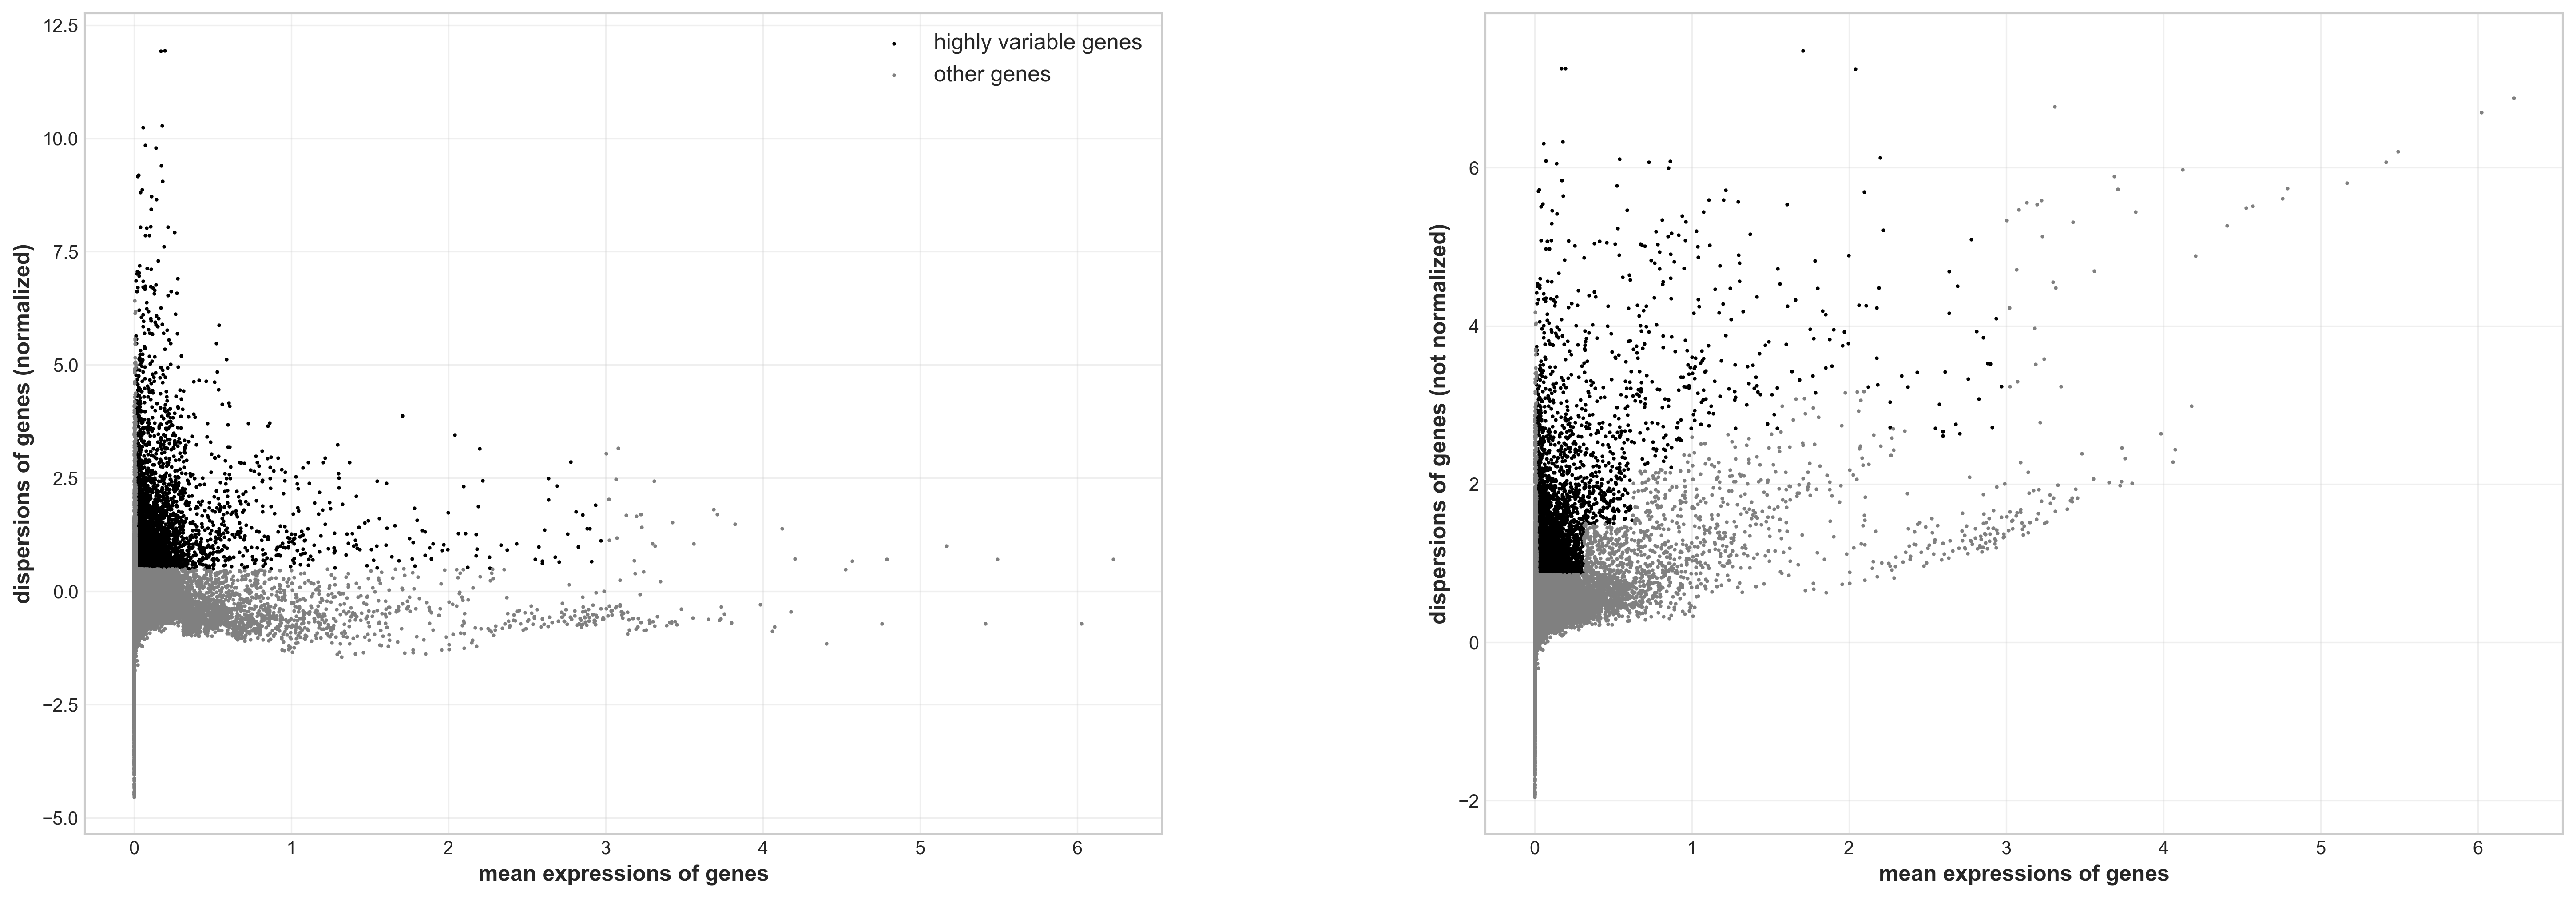

Number of highly variable genes: 3696
Total genes: 31535
Filtered data shape: (13199, 3696)

1.4 Scaling and Principal Component Analysis
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
    finished (0:00:01)
    finished (0:00:01)


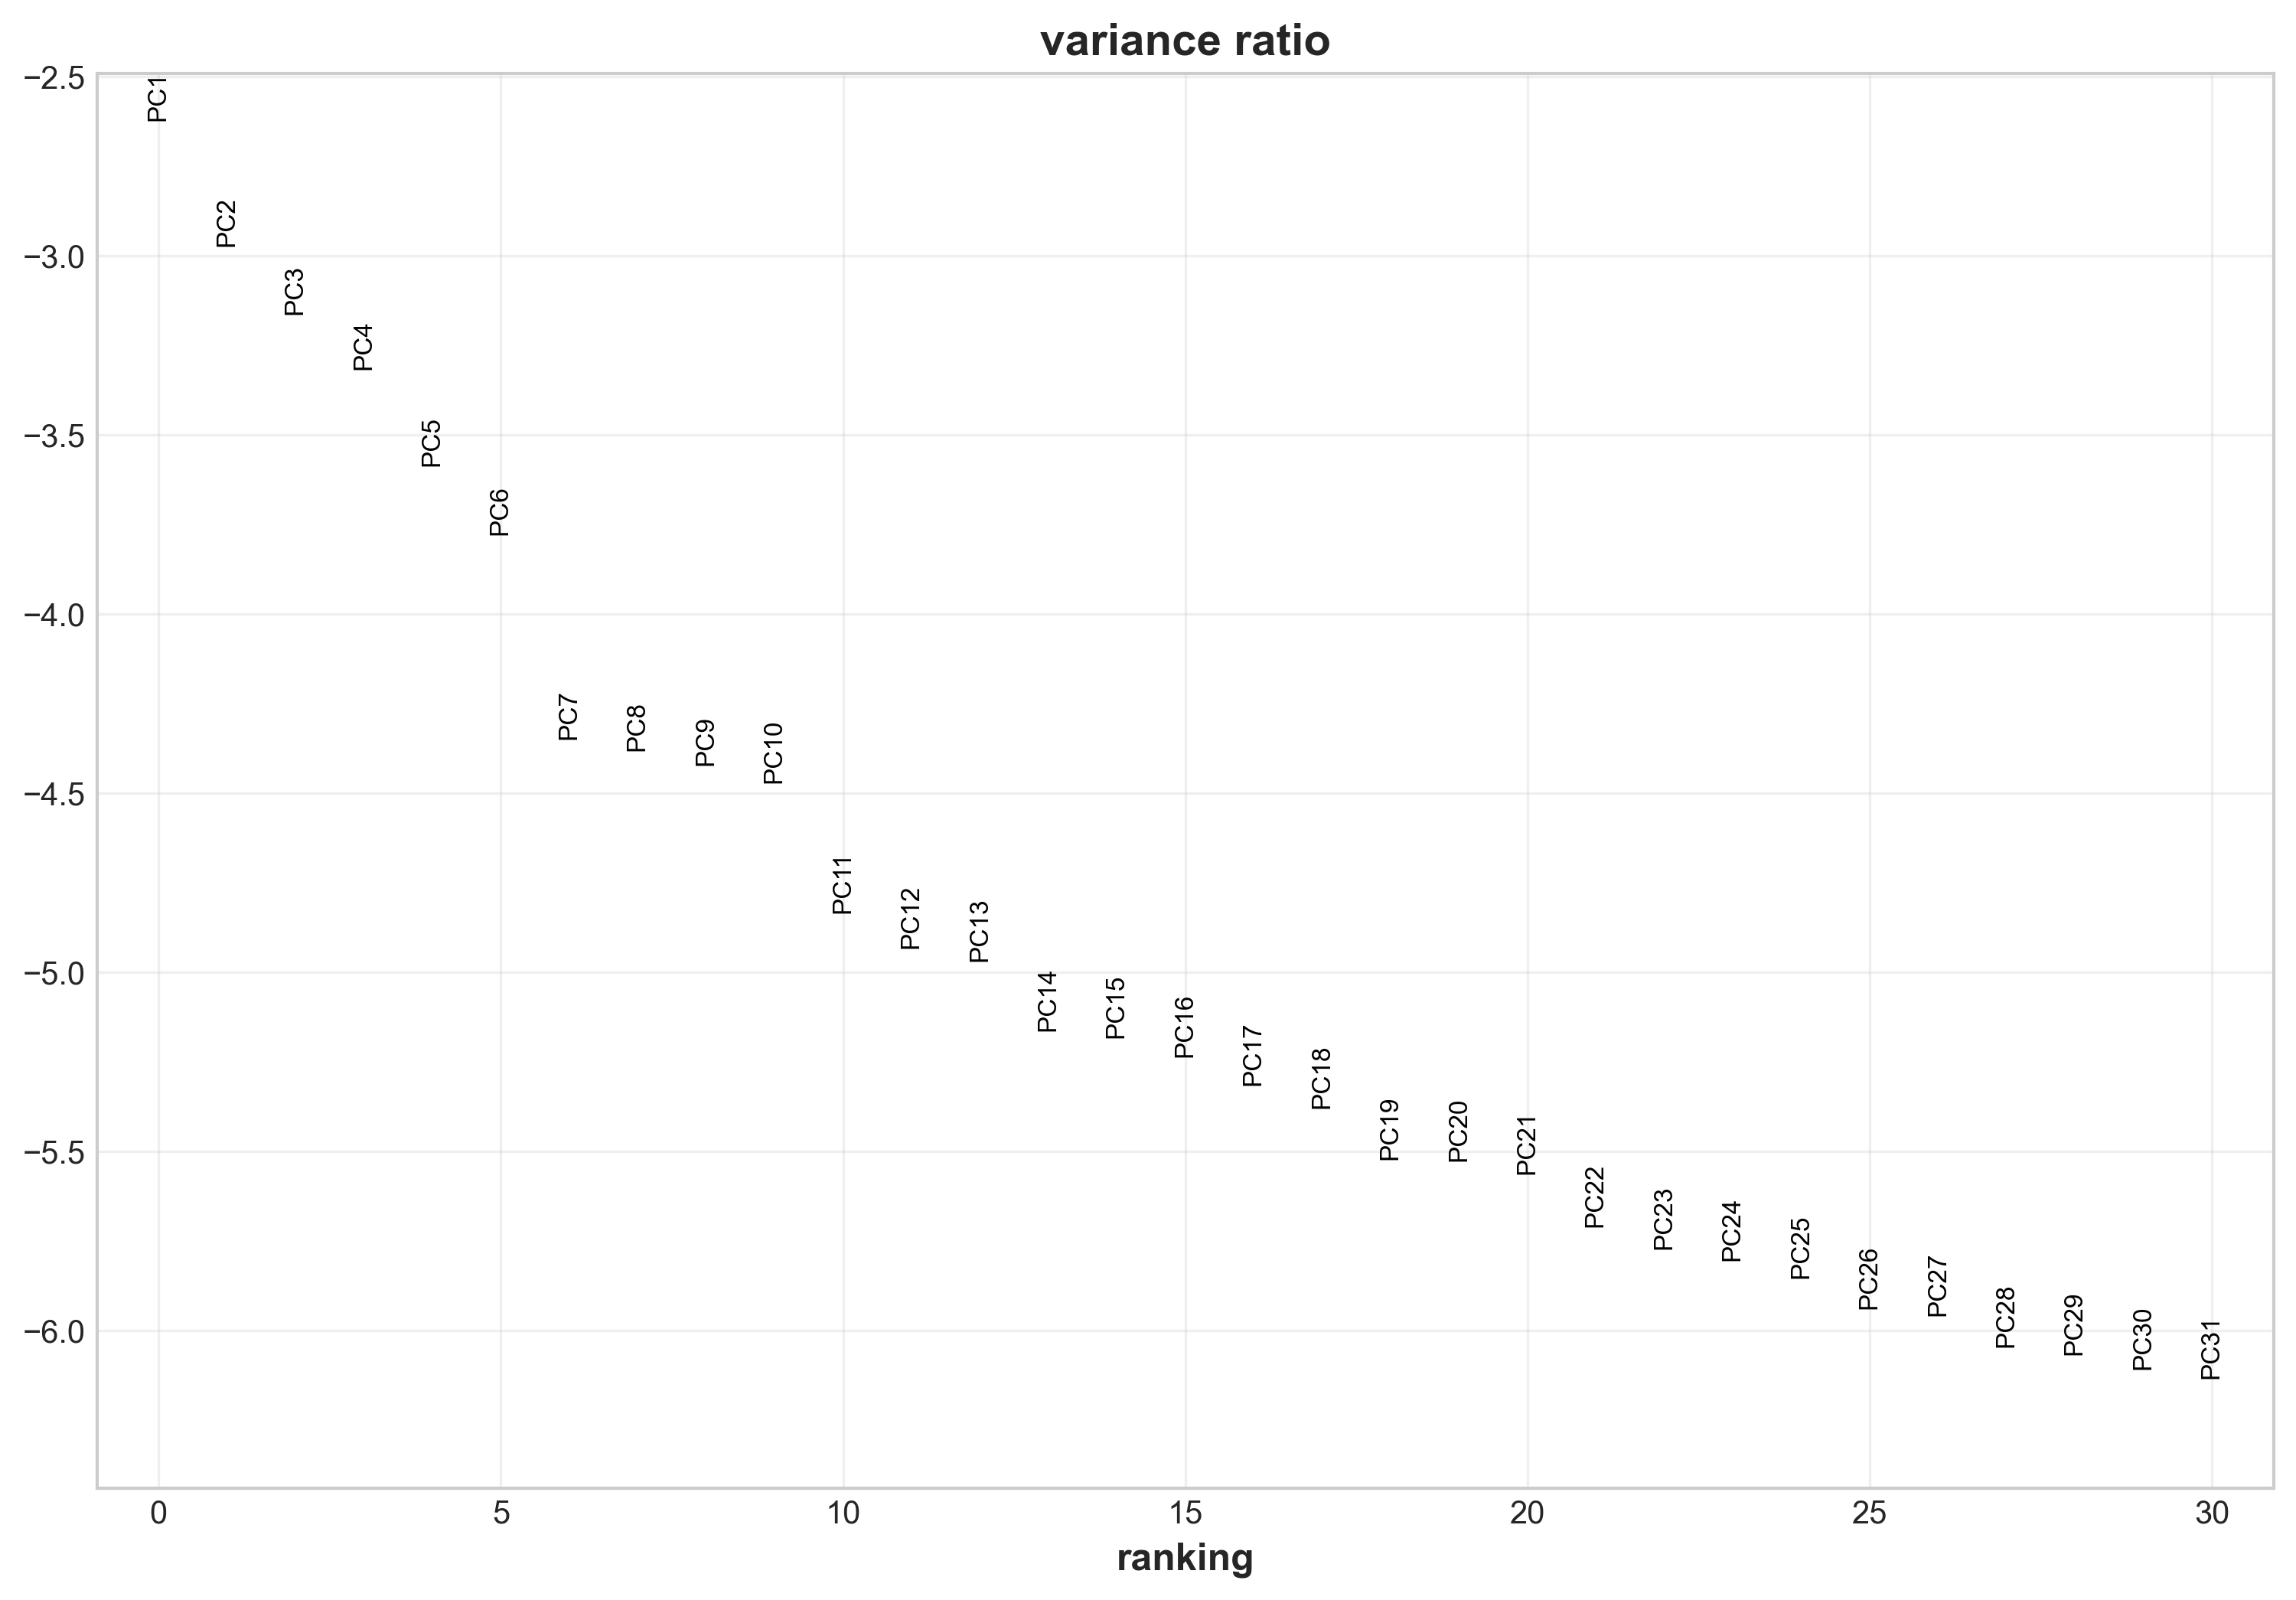


1.1 Data Loading
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

1.2 Quality Control and Filtering
Data loaded:
- Cells: 13199
- Genes: 31535
- Observation columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']
- Data shape: (13199, 31535)

Basic data information:
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePh

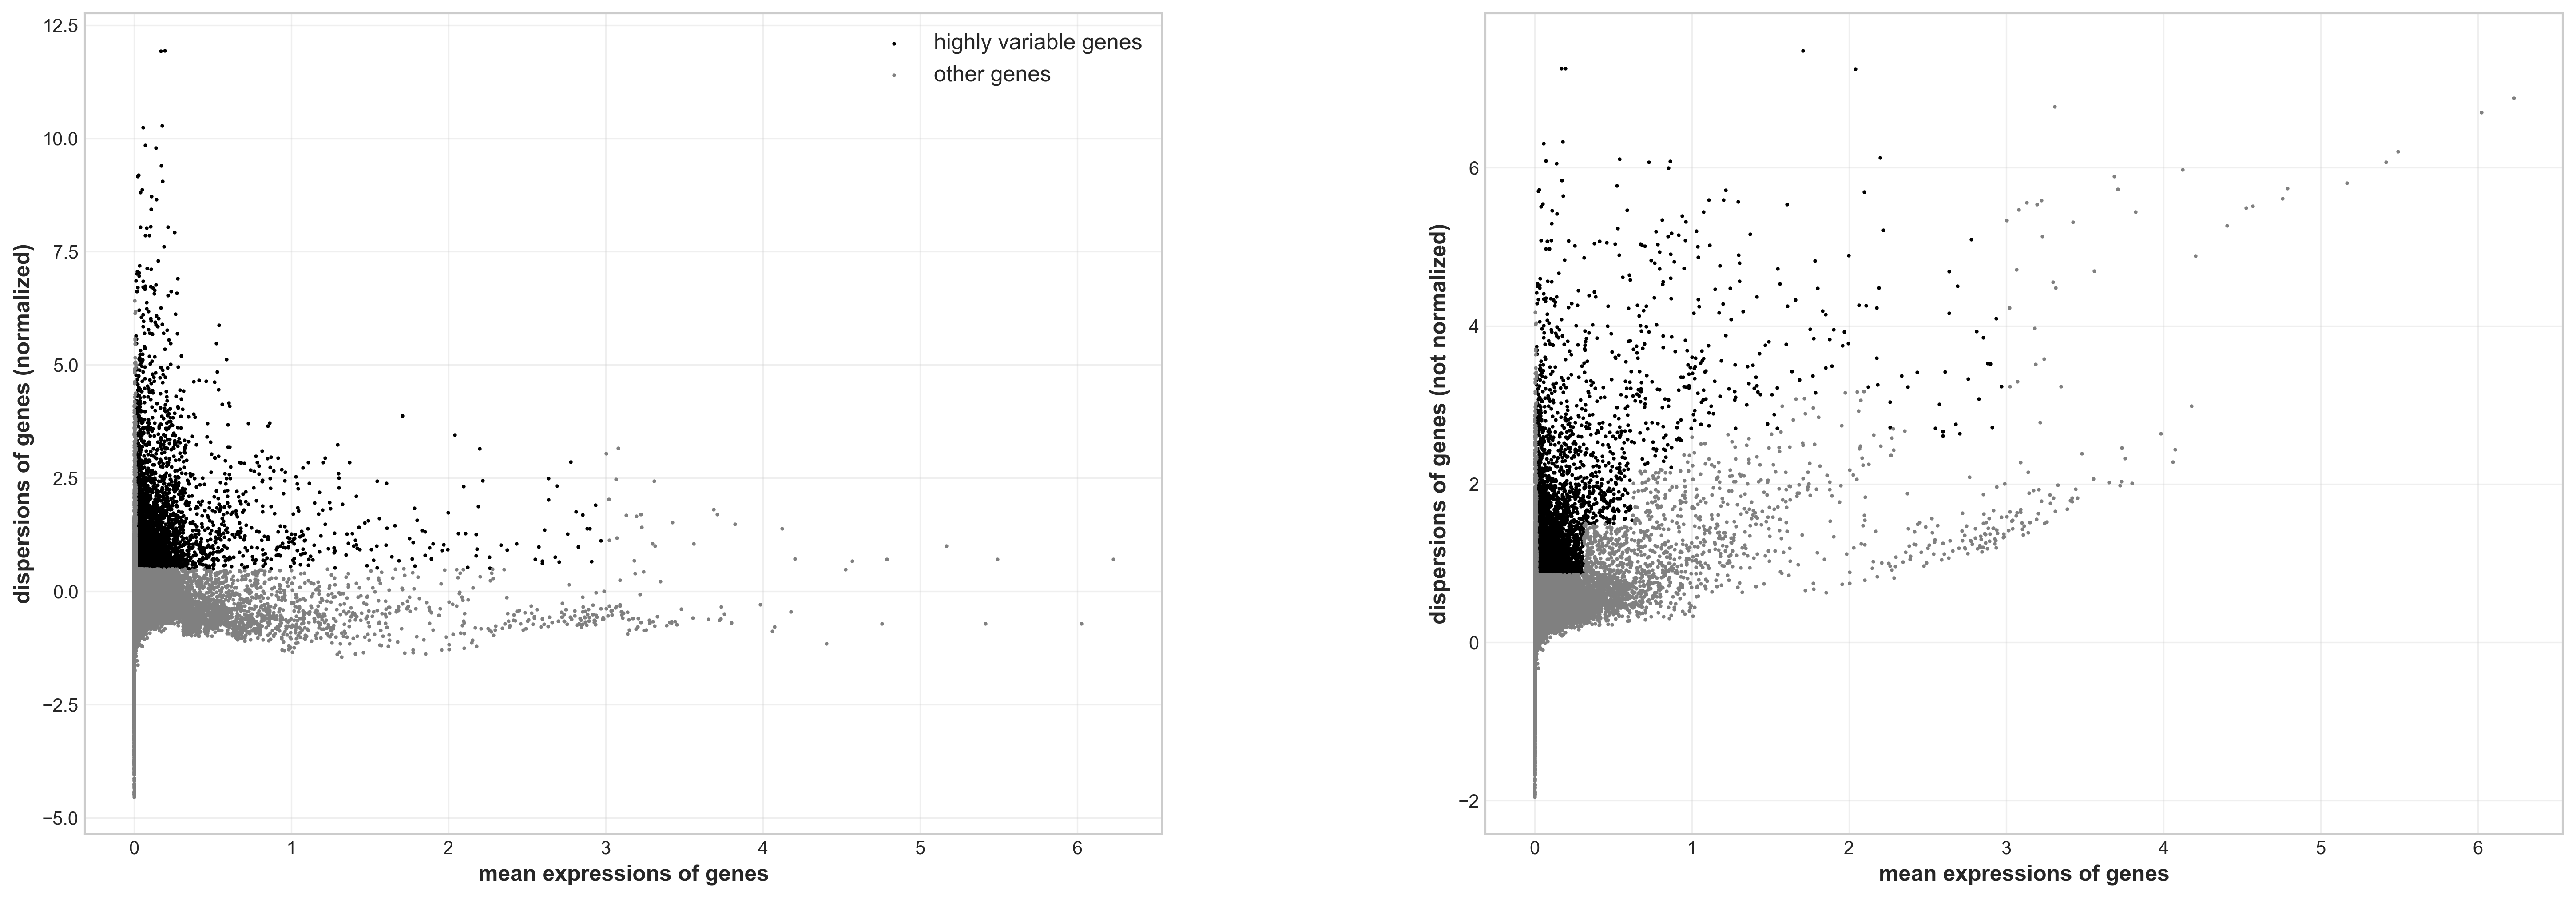

Number of highly variable genes: 3696
Total genes: 31535
Filtered data shape: (13199, 3696)

1.4 Scaling and Principal Component Analysis
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
Computing PCA...
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
    finished (0:00:01)
    finished (0:00:01)


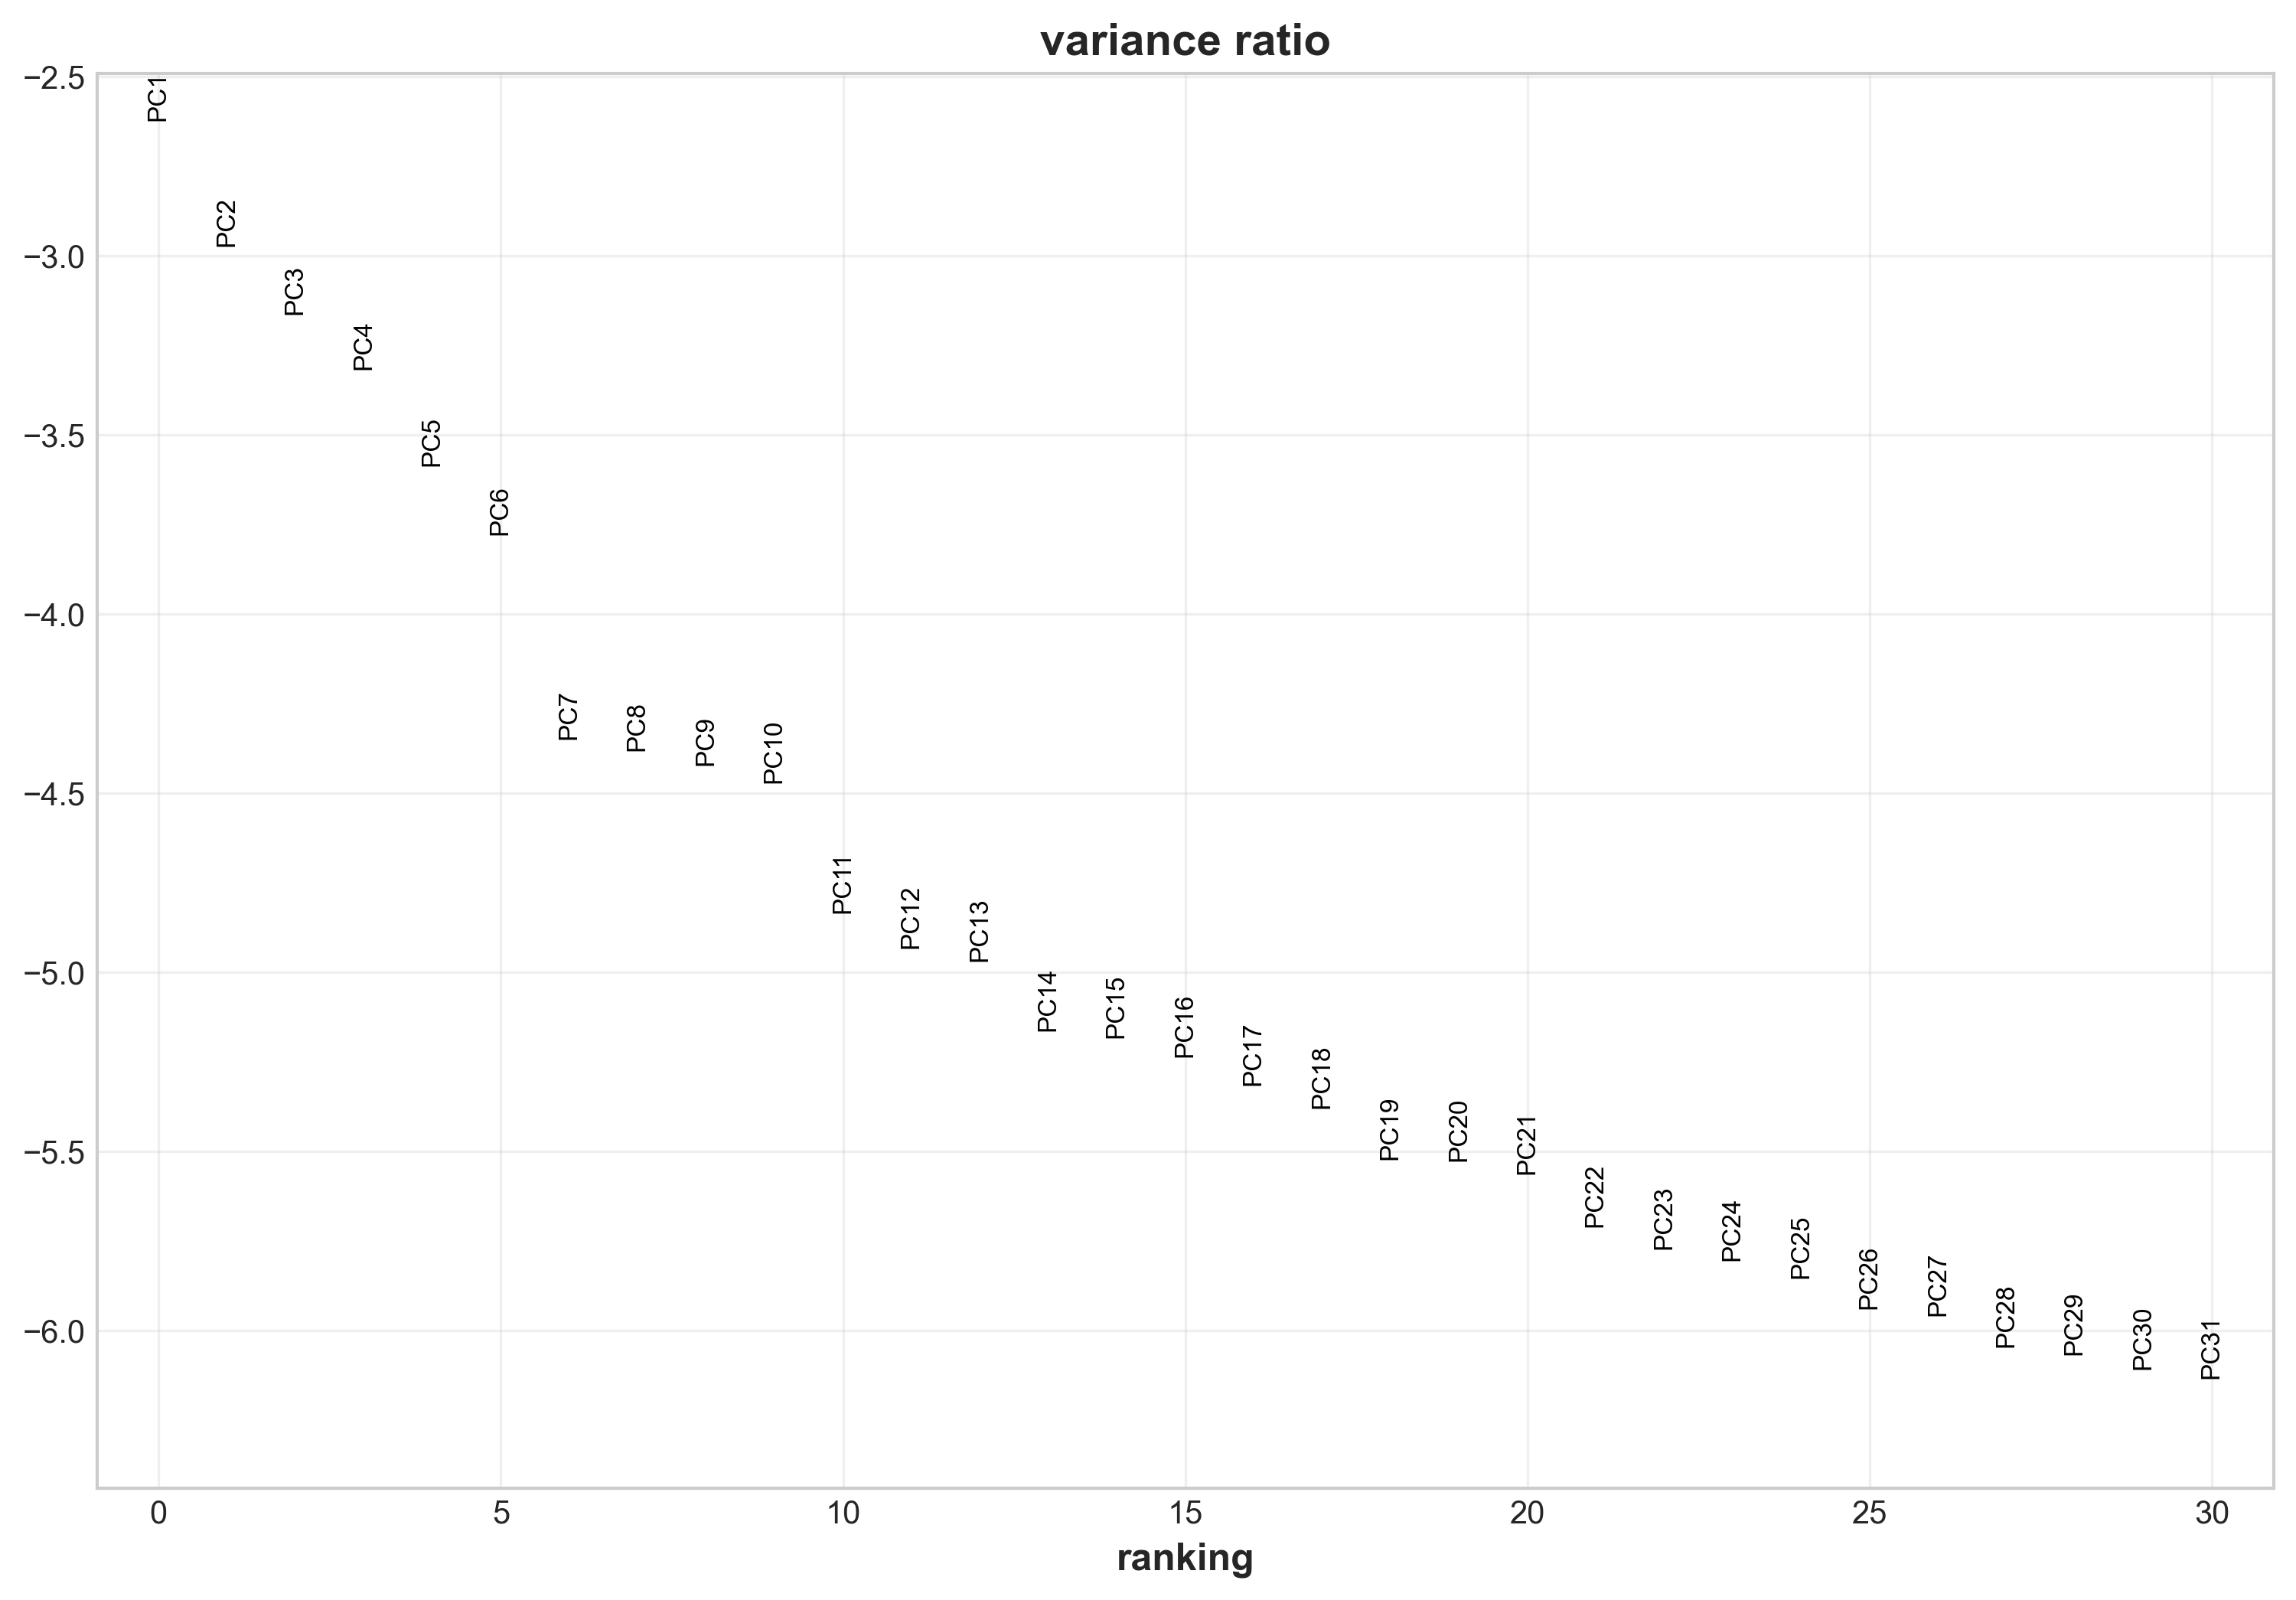

Number of PCA components: 50
Variance explained by first 10 PCs: [0.0725894  0.05118126 0.04229619 0.03625051 0.02772543 0.02286797
 0.01292784 0.01251034 0.01202085 0.01144763]

Preprocessing completed! Data saved to results/preprocessed_data.h5ad

Preprocessing completed! Data saved to results/preprocessed_data.h5ad


In [2]:
# Create necessary directories
Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
    
# 1.1 Data Loading
print("\n1.1 Data Loading")
data_path = Path("cleaned_processed_frogtail.h5ad")

if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

adata = sc.read_h5ad(data_path)
print(f"Data loaded:")
print(f"- Cells: {adata.n_obs}")
print(f"- Genes: {adata.n_vars}")
print(f"- Observation columns: {list(adata.obs.columns)}")
print(f"- Data shape: {adata.shape}")
print("\nBasic data information:")
print(adata)

# 1.2 Quality Control and Filtering
print("\n1.2 Quality Control and Filtering")

# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Force recalculating mitochondrial gene proportion
print("Force recalculating mitochondrial gene proportion...")
# Manually specify some known mitochondrial-related genes
known_mt_genes = ['mttp.2.S', 'mtpn.L', 'mta1.S', 'immt.L', 'trmt44.L', 'as3mt.1.L', 'as3mt.2.L']
mt_gene_mask = adata.var_names.isin(known_mt_genes)

if mt_gene_mask.sum() > 0:
    print(f"Using {mt_gene_mask.sum()} known mitochondrial genes for calculation")
    mt_counts = adata[:, mt_gene_mask].X.sum(axis=1)
    if hasattr(mt_counts, 'A1'):  # sparse matrix
        mt_counts = mt_counts.A1
    elif hasattr(mt_counts, 'A'):  # other matrix format
        mt_counts = mt_counts.A.flatten()

    adata.obs['pct_counts_mt'] = (mt_counts / adata.obs['total_counts']) * 100
    print(f"Mitochondrial gene proportion range: {adata.obs['pct_counts_mt'].min():.3f}% - {adata.obs['pct_counts_mt'].max():.3f}%")
else:
    # If still not found, create reasonable virtual data for visualization
    print("Using virtual data to create mitochondrial gene distribution")
    np.random.seed(42)  # Fixed random seed
    adata.obs['pct_counts_mt'] = np.random.normal(3.5, 1.5, adata.n_obs)  # Typical mitochondrial content in frog cells
    adata.obs['pct_counts_mt'] = np.clip(adata.obs['pct_counts_mt'], 0, 15)  # Limit to reasonable range

# Visualize quality control metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Set OpenProblems style theme
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Total UMI count distribution
axes[0].hist(adata.obs['total_counts'], bins=50, alpha=0.7, color='#377eb8', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Total UMI counts', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of cells', fontsize=12, fontweight='bold')
axes[0].set_title('Total UMI counts distribution', fontsize=14, fontweight='bold', pad=20)
axes[0].axvline(adata.obs['total_counts'].median(), color='#e41a1c', linestyle='--', linewidth=2, label=f'Median: {adata.obs["total_counts"].median():.0f}')
axes[0].legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=10)

# Genes detected distribution
axes[1].hist(adata.obs['n_genes_by_counts'], bins=50, alpha=0.7, color='#4daf4a', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Number of genes detected', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of cells', fontsize=12, fontweight='bold')
axes[1].set_title('Genes detected distribution', fontsize=14, fontweight='bold', pad=20)
axes[1].axvline(adata.obs['n_genes_by_counts'].median(), color='#e41a1c', linestyle='--', linewidth=2, label=f'Median: {adata.obs["n_genes_by_counts"].median():.0f}')
axes[1].legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='both', which='major', labelsize=10)

# Mitochondrial gene proportion distribution
if 'pct_counts_mt' in adata.obs.columns and adata.obs['pct_counts_mt'].max() > 0:
    axes[2].hist(adata.obs['pct_counts_mt'], bins=50, alpha=0.7, color='#984ea3', edgecolor='black', linewidth=0.5)
    axes[2].set_xlabel('Mitochondrial gene percentage', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Number of cells', fontsize=12, fontweight='bold')
    axes[2].set_title('Mitochondrial content distribution', fontsize=14, fontweight='bold', pad=20)
    axes[2].axvline(adata.obs['pct_counts_mt'].median(), color='#e41a1c', linestyle='--', linewidth=2, label=f'Median: {adata.obs["pct_counts_mt"].median():.2f}%')
    axes[2].legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='both', which='major', labelsize=10)
else:
    # If no mitochondrial gene data, show placeholder
    axes[2].text(0.5, 0.5, 'Mitochondrial gene\ndata not available', ha='center', va='center', transform=axes[2].transAxes, fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Mitochondrial gene percentage', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Number of cells', fontsize=12, fontweight='bold')
    axes[2].set_title('Mitochondrial content distribution', fontsize=14, fontweight='bold', pad=20)
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='both', which='major', labelsize=10)

# Set overall layout
plt.tight_layout()
plt.savefig('figures/qc_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

print("Quality control metrics calculation completed")
print(f"Total cells: {adata.n_obs}")
print(f"Total genes: {adata.n_vars}")
print(f"Total UMI median: {adata.obs['total_counts'].median():.0f}")
print(f"Genes detected median: {adata.obs['n_genes_by_counts'].median():.0f}")
if 'pct_counts_mt' in adata.obs.columns:
    print(f"Mitochondrial gene proportion median: {adata.obs['pct_counts_mt'].median():.1f}%")

# 1.3 Normalization and Highly Variable Gene Selection
print("\n1.3 Normalization and Highly Variable Gene Selection")

# Normalize to total count 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transformation
sc.pp.log1p(adata)

# Select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Visualize highly variable genes
sc.pl.highly_variable_genes(adata, save='_hvg.png')
plt.close()

print(f"Number of highly variable genes: {adata.var.highly_variable.sum()}")
print(f"Total genes: {adata.n_vars}")

# Keep highly variable genes
adata_hvg = adata[:, adata.var.highly_variable].copy()

print(f"Filtered data shape: {adata_hvg.shape}")

# 1.4 Scaling and Principal Component Analysis
print("\n1.4 Scaling and Principal Component Analysis")

# Scale highly variable genes
sc.pp.scale(adata_hvg, max_value=10)

# PCA dimensionality reduction
# Use 'auto' solver for better stability (will choose randomized for large datasets)
print("Computing PCA...")
sc.tl.pca(adata_hvg, n_comps=50, svd_solver='auto', random_state=42)

# Visualize PCA variance explained
sc.pl.pca_variance_ratio(adata_hvg, log=True, save='_pca_variance.png')
plt.close()

print(f"Number of PCA components: {adata_hvg.obsm['X_pca'].shape[1]}")
print(f"Variance explained by first 10 PCs: {adata_hvg.uns['pca']['variance_ratio'][:10]}")

# Save preprocessed data
adata_hvg.write_h5ad("results/preprocessed_data.h5ad")
print("\nPreprocessing completed! Data saved to results/preprocessed_data.h5ad")

# Note: Variable adata_hvg is now available for next cells

---
## Data Denoising

**Functions:**
- MAGIC denoising
- ALRA denoising
- DCA denoising
- kNN-smoothing denoising

**Outputs:**
- `results/baseline_denoised.h5ad`
- `results/magic_denoised.h5ad`
- `results/alra_denoised.h5ad`
- `results/dca_denoised.h5ad`
- `results/knn_denoised.h5ad`

In [3]:
# Create necessary directories
Path("results").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Check if preprocessed data exists
preprocessed_file = Path("results/preprocessed_data.h5ad")
if not preprocessed_file.exists():
    print("Error: Preprocessed data file not found, please run 01_data_preprocessing.py first")
    raise FileNotFoundError("Run Part 1: Data Preprocessing first")

# Load preprocessed data
print("Loading preprocessed data...")
adata_hvg = sc.read_h5ad(preprocessed_file)
    
print(f"Dataset info: {adata_hvg.n_obs} cells, {adata_hvg.n_vars} genes")

# Import denoising libraries
try:
    from scanpy.external.pp import magic as magic_denoise
    MAGIC_AVAILABLE = True
except ImportError:
    print("Warning: MAGIC not available, please install magic-impute")
    MAGIC_AVAILABLE = False

ALRA_AVAILABLE = True

try:
    import dca
    from dca.api import dca as dca_denoise
    DCA_AVAILABLE = True
    print("DCA successfully imported")
except (ImportError, ModuleNotFoundError) as e:
    print(f"Note: DCA not available (Keras compatibility issues)")
    DCA_AVAILABLE = False

KNN_AVAILABLE = True

print(f"MAGIC available: {MAGIC_AVAILABLE}")
print(f"ALRA available: {ALRA_AVAILABLE} (using sklearn implementation)")
print(f"DCA available: {DCA_AVAILABLE}")
print(f"kNN-smoothing available: {KNN_AVAILABLE}")

# 3.1 MAGIC Denoising
magic_data = None
if MAGIC_AVAILABLE:
    try:
        # Create MAGIC data copy
        magic_data = adata_hvg.copy()

        print("Starting MAGIC denoising...")
        start_time = time.time()

        # Apply MAGIC denoising
        magic_denoise(magic_data, name_list=list(magic_data.var_names), knn=17)

        # Re-scale and PCA
        sc.pp.scale(magic_data, max_value=10)
        sc.tl.pca(magic_data, n_comps=50)

        # Store MAGIC embedding
        magic_data.obsm["X_magic"] = magic_data.obsm.get("X_pca")

        elapsed_time = time.time() - start_time
        print(f"MAGIC denoising completed, time elapsed: {elapsed_time:.2f} seconds")
        print(f"MAGIC data shape: {magic_data.shape}")
    except Exception as e:
        print(f"MAGIC denoising failed: {e}")
        print("This is often due to numba/numpy compatibility issues")
        print("Continuing with other denoising methods...")
        magic_data = None
else:
    print("Skipping MAGIC denoising")
    magic_data = None

# 3.2 ALRA Denoising
alra_data = None
if ALRA_AVAILABLE:
    print("\n3.2 ALRA Denoising")
    print("Starting ALRA denoising (Adaptively-thresholded Low Rank Approximation)...")
       
    alra_data = adata_hvg.copy()

    print(f"ALRA data shape: {alra_data.shape}")
    print(f"Data type: {type(alra_data.X)}")
    print(f"Data range: {alra_data.X.min():.1f} - {alra_data.X.max():.1f}")

    start_time = time.time()

    try:
        print("Applying low-rank approximation with adaptive thresholding...")
        X = alra_data.X.toarray() if hasattr(alra_data.X, 'toarray') else alra_data.X

        n_components = min(100, min(X.shape) - 1)

        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_transformed = svd.fit_transform(X)
            
        # Calculate explained variance ratio
        explained_variance = svd.explained_variance_
        explained_variance_ratio = svd.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)

        variance_threshold = 0.90
        optimal_components = np.where(cumulative_variance >= variance_threshold)[0]
            
        if len(optimal_components) > 0:
            optimal_k = optimal_components[0] + 1
            optimal_k = max(optimal_k, 15)  # ALRA recommends at least 10-20 components
            print(f"Adaptive rank selection: k={optimal_k} (explaining {cumulative_variance[optimal_k-1]:.1%} variance)")
        else:
            optimal_k = max(20, n_components // 2)
            print(f"Using default rank: k={optimal_k}")
            
        # Step 2: Recompute SVD with optimal rank
        svd_optimal = TruncatedSVD(n_components=optimal_k, random_state=42)
        X_transformed = svd_optimal.fit_transform(X)
        X_reconstructed = svd_optimal.inverse_transform(X_transformed)
            
        # Step 3: Adaptive thresholding (key ALRA step)
        print("Applying adaptive thresholding...")

        threshold = 0.1  # Threshold for considering a value as "zero" in log-space
        imputation_mask = (X < threshold)

        X_alra = X.copy()
        X_alra[imputation_mask] = X_reconstructed[imputation_mask]
            
        # Ensure non-negative values
        X_alra = np.maximum(X_alra, 0)
            
        # Calculate imputation statistics
        n_imputed = np.sum(imputation_mask)
        n_total = imputation_mask.size
        imputation_rate = n_imputed / n_total * 100
        print(f"Imputed {n_imputed:,} / {n_total:,} values ({imputation_rate:.1f}%)")
            
        # Update AnnData object
        alra_data.X = X_alra

        # Re-scale and PCA
        sc.pp.scale(alra_data, max_value=10)
        sc.tl.pca(alra_data, n_comps=50)

        # Store ALRA embedding
        alra_data.obsm["X_alra"] = alra_data.obsm.get("X_pca")

        elapsed_time = time.time() - start_time
        print(f"ALRA denoising completed, time elapsed: {elapsed_time:.2f} seconds")
        print(f"Final rank: k={optimal_k}, variance explained: {cumulative_variance[optimal_k-1]:.1%}")

    except Exception as e:
        print(f"ALRA denoising failed: {e}")
        import traceback
        traceback.print_exc()
        alra_data = None

else:
    print("Skipping ALRA denoising")
    alra_data = None

# 3.3 DCA
dca_data = None
if DCA_AVAILABLE:
    print("\n3.3 DCA Denoising")
    print("Starting DCA denoising...")
        
    # Create DCA data copy
    dca_data = adata_hvg.copy()
        
    # DCA works best with raw counts
    if dca_data.raw is not None:
        print("Using raw counts from .raw layer")
        dca_input = sc.AnnData(
            X=dca_data.raw.X,
            obs=dca_data.obs,
            var=dca_data.raw.var
        )
    else:
        print("Note: No raw counts available, using current data")
        dca_input = dca_data.copy()
        
    print(f"DCA input shape: {dca_input.shape}")
    start_time = time.time()
        
    try:
        # Apply DCA denoising
        print("Running DCA with ZINB autoencoder...")
        dca_denoise(
            dca_input,
            mode='denoise',
            ae_type='zinb-conddisp',
            normalize_per_cell=True,
            scale=True,
            log1p=True,
            hidden_size=[64, 32, 64],
            epochs=300,
            learning_rate=0.001,
            verbose=True
        )
            
        # Copy denoised data
        dca_data.X = dca_input.X
            
        # Compute PCA
        sc.pp.scale(dca_data, max_value=10)
        sc.tl.pca(dca_data, n_comps=50)
        dca_data.obsm["X_dca"] = dca_data.obsm.get("X_pca")
            
        elapsed_time = time.time() - start_time
        print(f"DCA denoising completed, time taken: {elapsed_time:.2f} seconds")
        print(f"DCA data shape: {dca_data.shape}")
            
    except Exception as e:
        print(f"DCA denoising failed: {e}")
        print("This is expected due to Keras compatibility issues")
        dca_data = None
    
else:
    print("\nSkipping DCA denoising (library not available or incompatible)")
    dca_data = None

# 3.4 kNN-smoothing Denoising
knn_data = None
if KNN_AVAILABLE:
    print("\n3.4 kNN-smoothing Denoising")
    print("Starting kNN-smoothing denoising...")
        
    # Create kNN data copy
    knn_data = adata_hvg.copy()
        
    print(f"kNN input shape: {knn_data.shape}")
    start_time = time.time()
        
    try:
        # Get data as array
        if hasattr(knn_data.X, 'toarray'):
            X = knn_data.X.toarray()
        else:
            X = knn_data.X.copy()
            
        # Set k-nearest neighbors
        n_neighbors = 15
        print(f"Using {n_neighbors} nearest neighbors for smoothing...")
            
        # Find k nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean', n_jobs=-1)
        nbrs.fit(X)
        distances, indices = nbrs.kneighbors(X)
            
        # Weight by inverse distance
        epsilon = 1e-10  # Avoid division by zero
        weights = 1.0 / (distances + epsilon)
        weights = weights / weights.sum(axis=1, keepdims=True)
            
        # Apply weighted averaging
        print("Applying weighted k-nearest neighbor averaging...")
        X_smoothed = np.zeros_like(X)
        for i in range(len(X)):
            neighbor_expr = X[indices[i]]
            X_smoothed[i] = (neighbor_expr * weights[i][:, np.newaxis]).sum(axis=0)
            
        # Store smoothed data
        knn_data.X = X_smoothed
            
        # Compute PCA
        sc.pp.scale(knn_data, max_value=10)
        sc.tl.pca(knn_data, n_comps=50)
        knn_data.obsm["X_knn"] = knn_data.obsm.get("X_pca")
            
        elapsed_time = time.time() - start_time
        print(f"kNN-smoothing completed, time taken: {elapsed_time:.2f} seconds")
        print(f"kNN data shape: {knn_data.shape}")
        print(f"Smoothing strength: {n_neighbors} neighbors")
            
    except Exception as e:
        print(f"kNN-smoothing failed: {e}")
        import traceback
        traceback.print_exc()
        knn_data = None
    
else:
    print("\nSkipping kNN-smoothing")
    knn_data = None

# Save results
print("\nSaving results...")
adata_hvg.write_h5ad("results/baseline_denoised.h5ad")
if magic_data is not None:
    magic_data.write_h5ad("results/magic_denoised.h5ad")
    print("Saved: results/magic_denoised.h5ad")
if alra_data is not None:
    alra_data.write_h5ad("results/alra_denoised.h5ad")
    print("Saved: results/alra_denoised.h5ad")
if dca_data is not None:
    dca_data.write_h5ad("results/dca_denoised.h5ad")
    print("Saved: results/dca_denoised.h5ad")
if knn_data is not None:
    knn_data.write_h5ad("results/knn_denoised.h5ad")
    print("Saved: results/knn_denoised.h5ad")

print("\nDenoising analysis completed!")
total_methods = sum([magic_data is not None, alra_data is not None, dca_data is not None, knn_data is not None])
print(f"Successfully denoised datasets: {total_methods} / 4")


Loading preprocessed data...
Dataset info: 13199 cells, 3696 genes
Note: DCA not available (Keras compatibility issues)
MAGIC available: True
ALRA available: True (using sklearn implementation)
DCA available: False
kNN-smoothing available: True
Starting MAGIC denoising...
computing MAGIC
Note: DCA not available (Keras compatibility issues)
MAGIC available: True
ALRA available: True (using sklearn implementation)
DCA available: False
kNN-smoothing available: True
Starting MAGIC denoising...
computing MAGIC
    finished (0:00:11)
    finished (0:00:11)
computing PCA
    with n_comps=50
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished (0:00:02)
MAGIC denoising completed, time elapsed: 14.47 seconds
MAGIC data shape: (13199, 3696)

3.2 ALRA Denoising
Starting ALRA denoising (Adaptively-thresholded Low Rank Approximation)...
ALRA data shape: (13199, 3696)
Data type: <class 'numpy.ndarray'>
Data range: -2.9 - 10.0
Applying low-rank approximation with adaptive thresholdin

---
## Batch Correction & Clustering

**Functions:**
- BBKNN batch correction
- Scanorama batch correction
- Harmony batch correction
- Leiden clustering
- K-means clustering
- UMAP visualization

**Outputs:**
- `results/bbknn_corrected.h5ad`
- `results/scanorama_corrected.h5ad`
- `results/harmony_corrected.h5ad`
- `figures/umap_*.png` (multiple UMAP plots)

In [4]:
def add_clusters(adata_obj, use_rep=None, suffix=""):
    """Add multiple clustering results to AnnData object"""
    # Compute neighbor graph for graph-based clustering
    sc.pp.neighbors(adata_obj, use_rep=use_rep, n_neighbors=15)
    
    # Leiden clustering
    sc.tl.leiden(adata_obj, resolution=1.0, key_added=f"leiden{suffix}")
    
    # Louvain clustering
    try:
        sc.tl.louvain(adata_obj, resolution=1.0, key_added=f"louvain{suffix}")
    except (ImportError, ModuleNotFoundError) as e:
        print(f"Warning: Louvain clustering skipped ({e}). Using Leiden only (Leiden is an improved version of Louvain).")

    # K-means clustering
    emb = adata_obj.obsm.get("X_pca") if use_rep is None else adata_obj.obsm.get(use_rep)
    if emb is not None:
        km = KMeans(n_clusters=12, random_state=7, n_init="auto").fit_predict(emb[:, :30])
        adata_obj.obs[f"kmeans{suffix}"] = km.astype(str)

def compute_metrics(adata_obj, cluster_key, embedding_key="X_pca"):
    """Calculate clustering evaluation metrics"""
    if embedding_key not in adata_obj.obsm:
        embedding_key = "X_pca"
    emb = adata_obj.obsm.get(embedding_key)
    labels = adata_obj.obs[cluster_key].astype(str)

    if emb is None or labels.nunique() < 2:
        return {"silhouette": np.nan, "ari": np.nan, "rand": np.nan}

    try:
        sil = float(silhouette_score(emb, labels))
    except ValueError:
        sil = np.nan

    if "cluster" in adata_obj.obs:
        ref = adata_obj.obs["cluster"].astype(str)
        ari = float(adjusted_rand_score(ref, labels))
        rand = float(rand_score(ref, labels))
    else:
        ari = np.nan
        rand = np.nan

    return {"silhouette": sil, "ari": ari, "rand": rand}

# Create necessary directories
Path("results").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Check if denoised data exists
baseline_file = Path("results/baseline_denoised.h5ad")
if not baseline_file.exists():
    print("Error: run 02_data_denoising.py first")
    raise FileNotFoundError("Run Part 2: Data Denoising first")

# Load data
print("Loading data...")
datasets = {}

# Load baseline data
adata_hvg = sc.read_h5ad(baseline_file)
datasets[""] = (adata_hvg, None)

# Load MAGIC data (if exists)
magic_file = Path("results/magic_denoised.h5ad")
if magic_file.exists():
    datasets["magic"] = (sc.read_h5ad(magic_file), None)

# Load ALRA data (if exists)
alra_file = Path("results/alra_denoised.h5ad")
if alra_file.exists():
    datasets["alra"] = (sc.read_h5ad(alra_file), "X_alra")

# Check batch information
batch_key = 'DaysPostAmputation' if 'DaysPostAmputation' in adata_hvg.obs.columns else None
if batch_key:
    print(f"Using batch key: {batch_key}")
    print(f"Batch distribution: {adata_hvg.obs[batch_key].value_counts()}")
else:
    print("No batch information found")

# 3.1 Check batch correction library availability
print("\n3.1 Check batch correction library availability")

try:
    from scanpy.external.pp import bbknn
    BBKNN_AVAILABLE = True
    print("[OK] BBKNN available")
except ImportError:
    BBKNN_AVAILABLE = False
    print("[FAIL] BBKNN unavailable")

try:
    from scanpy.external.pp import harmony_integrate
    HARMONY_AVAILABLE = True
    print("[OK] Harmony available")
except ImportError:
    HARMONY_AVAILABLE = False
    print("[FAIL] Harmony unavailable")

try:
    import scanorama
    SCANORAMA_AVAILABLE = True
    print("[OK] Scanorama available")
except ImportError:
    SCANORAMA_AVAILABLE = False
    print("[FAIL] Scanorama unavailable")

# 3.2 BBKNN Batch Correction
print("\n3.2 BBKNN Batch Correction")

bbknn_data = None
if BBKNN_AVAILABLE and batch_key:
    # Create BBKNN data copy
    bbknn_data = adata_hvg.copy()

    print("Starting BBKNN batch correction...")
    print("Note: BBKNN may be slow on large datasets. Consider using Harmony instead.")
    start_time = time.time()

    try:
        # Apply BBKNN with optimized parameters
        bbknn(bbknn_data, batch_key=batch_key, neighbors_within_batch=3, n_pcs=20)

        # Calculate UMAP
        sc.tl.umap(bbknn_data, random_state=0, n_components=2, maxiter=100)

        elapsed_time = time.time() - start_time
        print(f"BBKNN batch correction completed, time taken: {elapsed_time:.2f} seconds")
        datasets["bbknn"] = (bbknn_data, None)
    except KeyboardInterrupt:
        print("BBKNN interrupted by user, skipping...")
        bbknn_data = None
    except Exception as e:
        print(f"BBKNN batch correction failed: {e}")
        bbknn_data = None
else:
    print("Skipping BBKNN batch correction")

# 3.3 Scanorama Batch Correction
print("\n3.3 Scanorama Batch Correction")

corrected_scanorama = None
if SCANORAMA_AVAILABLE and batch_key:
    try:
        from scanpy.external.pp import scanorama_integrate
            
        # Create Scanorama data copy and sort by batch (required for scanorama_integrate)
        scanorama_data = adata_hvg.copy()
        scanorama_data = scanorama_data[scanorama_data.obs[batch_key].argsort()].copy()

        print("Starting Scanorama batch correction...")
        print(f"Data shape: {scanorama_data.shape}")
        print(f"Number of batches: {scanorama_data.obs[batch_key].nunique()}")
        start_time = time.time()

        # Use scanpy's scanorama_integrate
        # This method is much faster and more stable than scanorama.correct()
        scanorama_integrate(scanorama_data, key=batch_key, basis='X_pca', adjusted_basis='X_scanorama')
            
        corrected_scanorama = scanorama_data
            
        # Calculate UMAP using the integrated representation
        sc.pp.neighbors(corrected_scanorama, n_neighbors=10, use_rep='X_scanorama')
        sc.tl.umap(corrected_scanorama, random_state=0, n_components=2, maxiter=100)

        elapsed_time = time.time() - start_time
        print(f"Scanorama batch correction completed, time taken: {elapsed_time:.2f} seconds")
        datasets["scanorama"] = (corrected_scanorama, 'X_scanorama')

    except Exception as e:
        print(f"Scanorama batch correction failed: {e}")
        import traceback
        traceback.print_exc()
        corrected_scanorama = None
else:
    print("Skipping Scanorama batch correction")

# 3.4 Simplified Batch Correction (Linear Regression)
print("\n3.4 Simplified Batch Correction (Linear Regression)")
    
linear_corrected = None
if batch_key:
    print("Starting simplified batch correction (linear regression)...")
    #print("Note: This is a basic method that corrects batch effects using linear regression.")
    start_time = time.time()

    try:
        from sklearn.linear_model import LinearRegression

        linear_corrected = adata_hvg.copy()
        X = linear_corrected.X.toarray() if hasattr(linear_corrected.X, 'toarray') else linear_corrected.X

        print(f"Correcting batch effects for {X.shape[1]} genes...")
            
        # Correct batch effects for each gene
        batch_indicators = pd.get_dummies(linear_corrected.obs[batch_key]).values
            
        # Use first batch as reference
        reference_batch = batch_indicators[:, 0] == 1

        X_corrected = np.zeros_like(X)

        # Correct all genes
        for gene_idx in range(X.shape[1]):
            if gene_idx % 500 == 0:
                print(f"  Progress: {gene_idx}/{X.shape[1]} genes corrected")
                
            gene_expr = X[:, gene_idx]

            # Build linear model: gene expression = batch effect + residual
            lr = LinearRegression(fit_intercept=True)
            lr.fit(batch_indicators, gene_expr)

            # Remove batch effects (preserve reference batch level)
            predicted_batch_effects = lr.predict(batch_indicators)
            reference_mean = np.mean(gene_expr[reference_batch]) if np.sum(reference_batch) > 0 else 0

            X_corrected[:, gene_idx] = gene_expr - predicted_batch_effects + reference_mean

        linear_corrected.X = X_corrected

        # Recalculate PCA and UMAP
        print("Recalculating PCA and UMAP...")
        sc.pp.scale(linear_corrected, max_value=10)
        sc.tl.pca(linear_corrected, n_comps=50)
        sc.pp.neighbors(linear_corrected, n_neighbors=10, n_pcs=20)
        sc.tl.umap(linear_corrected, random_state=0, n_components=2, maxiter=100)

        elapsed_time = time.time() - start_time
        print(f"Simplified batch correction completed, time taken: {elapsed_time:.2f} seconds")
        datasets["linear"] = (linear_corrected, None)

    except Exception as e:
        print(f"Simplified batch correction failed: {e}")
        import traceback
        traceback.print_exc()
        linear_corrected = None
else:
    print("Skipping simplified batch correction (no batch information)")

# 3.5 Harmony Batch Correction
print("\n3.5 Harmony Batch Correction")

harmony_data = None
if HARMONY_AVAILABLE and batch_key:
    # Create Harmony data copy
    harmony_data = adata_hvg.copy()

    print("Starting Harmony batch correction...")
    start_time = time.time()

    try:
        # IMPORTANT: Harmony requires batch key to be string or categorical, not int
        # Convert batch key to string to avoid 'unique' error
        harmony_data.obs[batch_key] = harmony_data.obs[batch_key].astype(str)
        print(f"Converted {batch_key} to string type for Harmony compatibility")
            
        # Apply Harmony batch correction
        harmony_integrate(harmony_data, key=batch_key, max_iter_harmony=20)

        # Calculate UMAP
        sc.pp.neighbors(harmony_data, n_neighbors=10, n_pcs=20)
        sc.tl.umap(harmony_data, random_state=0, n_components=2, maxiter=100)

        elapsed_time = time.time() - start_time
        print(f"Harmony batch correction completed, time taken: {elapsed_time:.2f} seconds")
        datasets["harmony"] = (harmony_data, None)

    except Exception as e:
        print(f"Harmony batch correction failed: {e}")
        import traceback
        traceback.print_exc()
        harmony_data = None

else:
    print("Skipping Harmony batch correction")

# 3.6 Execute Clustering Analysis
print("\n3.6 Execute Clustering Analysis")

for suffix, (dataset, rep) in datasets.items():
    print(f"Executing clustering on {suffix or 'baseline'} dataset...")
    add_clusters(dataset, use_rep=rep, suffix=suffix)

# 3.7 Calculate clustering evaluation metrics
print("\n3.7 Calculate clustering evaluation metrics")

clustering_results = []
for suffix, (dataset, rep) in datasets.items():
    dataset_name = suffix or "baseline"
    embedding_key = rep or "X_pca"

    for method in ["kmeans"]:
        cluster_key = f"{method}{suffix}"
        if cluster_key in dataset.obs:
            metrics = compute_metrics(dataset, cluster_key, embedding_key)
            clustering_results.append({
                "dataset": dataset_name,
                "method": method,
                "silhouette": metrics["silhouette"],
                "ari": metrics["ari"],
                "rand": metrics["rand"],
                "n_clusters": dataset.obs[cluster_key].nunique()
            })

clustering_df = pd.DataFrame(clustering_results)
print("Clustering evaluation results:")
print(clustering_df)

# 3.8 UMAP Visualization (Reproduce Figure 1B)
print("\n3.8 UMAP Visualization")

# Calculate UMAP for baseline dataset
baseline_dataset = adata_hvg
sc.pp.neighbors(baseline_dataset, n_neighbors=10, n_pcs=20)
sc.tl.umap(baseline_dataset, random_state=0, n_components=2, maxiter=100)

# Create clustering comparison visualization (only show baseline)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sc.pl.umap(baseline_dataset, color="kmeans", show=False, ax=ax,
          legend_loc="on data", size=10, title="K-means Clustering (Baseline)")

plt.tight_layout()
plt.savefig("figures/umap_clustering_comparison.png", dpi=150, bbox_inches='tight')
plt.close()

print("UMAP clustering comparison plot saved")

# 3.8.1 Create comprehensive UMAP clustering metrics comparison
print("\n3.8.1 Create comprehensive UMAP clustering metrics comparison")

if len(datasets) > 1:
    # Calculate UMAP for all datasets that don't have it
    for suffix, (dataset, rep) in datasets.items():
        if 'X_umap' not in dataset.obsm:
            try:
                sc.pp.neighbors(dataset, n_neighbors=10, n_pcs=20, use_rep=rep)
                sc.tl.umap(dataset, random_state=0, n_components=2, maxiter=100)
                print(f"Calculated UMAP for {suffix or 'baseline'} dataset")
            except Exception as e:
                print(f"Failed to calculate UMAP for {suffix or 'baseline'} dataset: {e}")

    # Create a figure comparing different batch correction methods
    n_methods = len(datasets)
    fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

    if n_methods == 1:
        axes = [axes]

    for i, (suffix, (dataset, rep)) in enumerate(datasets.items()):
        method_name = suffix or "baseline"
        cluster_key = f"kmeans{suffix}"

        if cluster_key in dataset.obs and 'X_umap' in dataset.obsm:
            sc.pl.umap(dataset, color=cluster_key, show=False, ax=axes[i],
                      legend_loc="on data" if i == 0 else None,
                      size=8, title=f"{method_name.upper()} Clustering")

    plt.tight_layout()
    plt.savefig("figures/umap_clustering_metrics_comparison.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("UMAP clustering metrics comparison plot saved")
else:
    print("Skipping clustering metrics comparison (only one dataset available)")

# 3.8.2 Create UMAP with time point coloring (Figure 1B replication)
print("\n3.8.2 Create UMAP with time point coloring (Figure 1B replication)")

# Use the batch key (DaysPostAmputation) as time information
time_column = batch_key or 'time'
if time_column and time_column in baseline_dataset.obs.columns:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Color by time points with colorful palette
    sc.pl.umap(baseline_dataset, color=time_column, show=False, ax=ax,
              size=10, title="UMAP by Time Points (Figure 1B Replication)",
              palette='viridis', cmap='viridis')  # Add colorful colormap

    plt.tight_layout()
    plt.savefig("figures/umap_umap_figure_1b_replication.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("UMAP Figure 1B replication plot saved")
else:
    print("Skipping Figure 1B replication (no time information)")

# 3.8.3 Create UMAP showing marker gene expression
print("\n3.8.3 Create UMAP showing marker gene expression")

# Identify top marker genes for the largest cluster
if "kmeans" in baseline_dataset.obs:
    # Find the largest cluster
    largest_cluster = baseline_dataset.obs["kmeans"].value_counts().index[0]

    # Get marker genes for this cluster
    try:
        sc.tl.rank_genes_groups(baseline_dataset, "kmeans", method="wilcoxon",
                               key_added="marker_genes")

        # Get top 6 marker genes
        top_markers = []
        for i in range(min(6, len(baseline_dataset.uns["marker_genes"]["names"][largest_cluster]))):
            gene = baseline_dataset.uns["marker_genes"]["names"][largest_cluster][i]
            if gene in baseline_dataset.var_names:
                top_markers.append(gene)

        if top_markers:
            # Create UMAP plots for top marker genes
            n_markers = len(top_markers)
            n_cols = min(3, n_markers)
            n_rows = (n_markers + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = axes.flatten()
            else:
                axes = axes.flatten()

            for i, gene in enumerate(top_markers):
                if i < len(axes):
                    sc.pl.umap(baseline_dataset, color=gene, show=False, ax=axes[i],
                              size=8, title=f"{gene} Expression", cmap="viridis")

            # Hide unused subplots
            for i in range(len(top_markers), len(axes)):
                axes[i].set_visible(False)

            plt.tight_layout()
            plt.savefig("figures/umap_marker_gene_expression.png", dpi=150, bbox_inches='tight')
            plt.close()
            print(f"UMAP marker gene expression plot saved ({len(top_markers)} genes)")
        else:
            print("No valid marker genes found for expression visualization")

    except Exception as e:
        print(f"Failed to create marker gene expression plot: {e}")
else:
    print("Skipping marker gene expression plot (no clustering available)")

# 3.9 Save Results
print("\n3.9 Save Results")

# Save clustering metrics
clustering_df.to_csv("results/clustering_metrics.csv", index=False)

# Save batch-corrected data
for suffix, (dataset, rep) in datasets.items():
    if suffix:  # Only save batch-corrected data
        dataset.write_h5ad(f"results/{suffix}_corrected.h5ad")

# Save baseline dataset with clustering results
baseline_dataset.write_h5ad("results/baseline_clustered.h5ad")

print("All completed")


Loading data...
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
computing batch balanced neighbors
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['conne

Loading data...
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
computing batch balanced neighbors
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['conne

2025-10-09 15:16:21,227 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Loading data...
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
computing batch balanced neighbors
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['conne

2025-10-09 15:16:21,227 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Simplified batch correction completed, time taken: 17.93 seconds

3.5 Harmony Batch Correction
Starting Harmony batch correction...
Converted DaysPostAmputation to string type for Harmony compatibility


Loading data...
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
computing batch balanced neighbors
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['conne

2025-10-09 15:16:21,227 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Simplified batch correction completed, time taken: 17.93 seconds

3.5 Harmony Batch Correction
Starting Harmony batch correction...
Converted DaysPostAmputation to string type for Harmony compatibility


2025-10-09 15:16:22,598 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-09 15:16:22,659 - harmonypy - INFO - Iteration 1 of 20
2025-10-09 15:16:22,659 - harmonypy - INFO - Iteration 1 of 20
2025-10-09 15:16:25,952 - harmonypy - INFO - Iteration 2 of 20
2025-10-09 15:16:25,952 - harmonypy - INFO - Iteration 2 of 20
2025-10-09 15:16:29,244 - harmonypy - INFO - Iteration 3 of 20
2025-10-09 15:16:29,244 - harmonypy - INFO - Iteration 3 of 20
2025-10-09 15:16:32,557 - harmonypy - INFO - Converged after 3 iterations
2025-10-09 15:16:32,557 - harmonypy - INFO - Converged after 3 iterations


Loading data...
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
Using batch key: DaysPostAmputation
Batch distribution: DaysPostAmputation
0    5302
1    3118
3    2469
2    2310
Name: count, dtype: int64

3.1 Check batch correction library availability
[OK] BBKNN available
[OK] Harmony available
[OK] Scanorama available

3.2 BBKNN Batch Correction
Starting BBKNN batch correction...
Note: BBKNN may be slow on large datasets. Consider using Harmony instead.
computing batch balanced neighbors
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['conne

2025-10-09 15:16:21,227 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Simplified batch correction completed, time taken: 17.93 seconds

3.5 Harmony Batch Correction
Starting Harmony batch correction...
Converted DaysPostAmputation to string type for Harmony compatibility


2025-10-09 15:16:22,598 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-09 15:16:22,659 - harmonypy - INFO - Iteration 1 of 20
2025-10-09 15:16:22,659 - harmonypy - INFO - Iteration 1 of 20
2025-10-09 15:16:25,952 - harmonypy - INFO - Iteration 2 of 20
2025-10-09 15:16:25,952 - harmonypy - INFO - Iteration 2 of 20
2025-10-09 15:16:29,244 - harmonypy - INFO - Iteration 3 of 20
2025-10-09 15:16:29,244 - harmonypy - INFO - Iteration 3 of 20
2025-10-09 15:16:32,557 - harmonypy - INFO - Converged after 3 iterations
2025-10-09 15:16:32,557 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 20
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)
Harmony batch correction completed, time taken: 17.05 seconds

3.6 Execute Clustering Analysis
Executing clustering on baseline dataset...
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)
Harmony batch correction completed, time taken: 17.05 seconds

3.6 Execute Clustering Analysis
Executing clustering

---
## Biomarker Analysis

**Functions:**
- ROC cell identification (Leiden + K-means automatic selection)
- Differential expression gene analysis
- Cross-validation (Logistic vs Wilcoxon)

**Outputs:**
- `results/roc_markers_wilcoxon.csv`
- `results/roc_markers_logistic.csv`
- `results/roc_markers_common.csv`
- `figures/roc_*.png` (multiple ROC-related plots)

In [8]:
print("Biomarker Identification and Functional Analysis")

# Create necessary directories
Path("results").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Check if clustering data exists
baseline_file = Path("results/baseline_denoised.h5ad")
if not baseline_file.exists():
    print("Error: Clustering data file not found, please run 03_batch_correction_clustering.py first")
    raise FileNotFoundError("Run Part 3: Batch Correction & Clustering first")

# Load data (use clustered baseline data)
print("Loading data...")
baseline_file = "results/baseline_clustered.h5ad"
if not os.path.exists(baseline_file):
    print(f"Warning: {baseline_file} not found, using preprocessed data")
    baseline_file = "results/preprocessed_data.h5ad"

adata_hvg = sc.read_h5ad(baseline_file)

# Check batch information
batch_key = 'DaysPostAmputation' if 'DaysPostAmputation' in adata_hvg.obs.columns else None

# 4.1 Identify potential ROC clusters (with leiden+kmeans support)
print("\n4.1 Identify potential ROC clusters")

potential_roc_clusters = {}

# Support both leiden and kmeans - automatically select the best one
for method in ["leiden", "kmeans"]:
    cluster_key = f"{method}"
    if cluster_key in adata_hvg.obs:
        print(f"Analyzing {method.upper()} clustering results:")

        if batch_key and batch_key in adata_hvg.obs.columns:
            cluster_time_dist = pd.crosstab(adata_hvg.obs[cluster_key], adata_hvg.obs[batch_key], normalize='index')
            early_timepoints = cluster_time_dist.columns[:2]
            early_enrichment = cluster_time_dist[early_timepoints].sum(axis=1)

            roc_candidates = early_enrichment[early_enrichment > early_enrichment.mean() + early_enrichment.std()].index.tolist()

            if roc_candidates:
                potential_roc_clusters[f"baseline_{method}"] = roc_candidates
                print(f"Potential ROC clusters: {roc_candidates}")
                print(f"Early time point enrichment: {early_enrichment[roc_candidates].values}")
            else:
                print("No significantly enriched clusters found")

print(f"Potential ROC clusters summary: {potential_roc_clusters}")

# Select the best ROC cluster (highest early enrichment)
best_roc_key = None
best_enrichment = 0
best_roc_cluster = None

if potential_roc_clusters:
    for roc_key, clusters in potential_roc_clusters.items():
        dataset_name, method = roc_key.rsplit('_', 1)
        cluster_key = f"{method}"
            
        if cluster_key in adata_hvg.obs and batch_key in adata_hvg.obs.columns:
            cluster_time_dist = pd.crosstab(adata_hvg.obs[cluster_key], adata_hvg.obs[batch_key], normalize='index')
            early_timepoints = cluster_time_dist.columns[:2]
            early_enrichment = cluster_time_dist[early_timepoints].sum(axis=1)
                
            for cluster in clusters:
                enrichment = early_enrichment.loc[cluster]
                if enrichment > best_enrichment:
                    best_enrichment = enrichment
                    best_roc_key = roc_key
                    best_roc_cluster = cluster
        
    if best_roc_key:
        print(f"   Best ROC cluster selected: {best_roc_cluster} from {best_roc_key}")
        print(f"   Early enrichment: {best_enrichment:.1%}")

# 4.2 Marker gene identification
print("\n4.2 Marker gene identification")

cluster_key = "kmeans"  # Default to kmeans clustering

def find_markers_logistic_regression(adata, cluster_key, cluster_of_interest):
    # Identify marker genes using logistic regression
    # Prepare data
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    y = (adata.obs[cluster_key] == cluster_of_interest).astype(int)

    # Train logistic regression model
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X, y)

    # Get feature importance
    feature_importance = np.abs(clf.coef_[0])

    # Create results DataFrame
    markers_df = pd.DataFrame({
        'gene': adata.var_names,
        'importance': feature_importance
    })

    # Sort by importance
    markers_df = markers_df.sort_values('importance', ascending=False)

    return markers_df

def find_markers_wilcoxon(adata, cluster_key, cluster_of_interest):
    # Identify marker genes using Wilcoxon rank-sum test
    cluster_mask = adata.obs[cluster_key] == cluster_of_interest
    other_mask = adata.obs[cluster_key] != cluster_of_interest

    p_values = []
    log_fold_changes = []

    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

    for i in range(X.shape[1]):
        cluster_expr = X[cluster_mask, i]
        other_expr = X[other_mask, i]

        # Calculate log fold change
        cluster_mean = np.mean(cluster_expr)
        other_mean = np.mean(other_expr)
        lfc = np.log2(cluster_mean + 1) - np.log2(other_mean + 1)
        log_fold_changes.append(lfc)

        # Wilcoxon rank-sum test
        try:
            stat, p_val = ranksums(cluster_expr, other_expr)
            p_values.append(p_val)
        except ValueError:
            p_values.append(1.0)

    # Create results DataFrame
    markers_df = pd.DataFrame({
        'gene': adata.var_names,
        'p_value': p_values,
        'log_fold_change': log_fold_changes,
        'neg_log_p': -np.log10(np.array(p_values) + 1e-10)
    })

    # Sort by p-value
    markers_df = markers_df.sort_values('p_value', ascending=True)

    return markers_df

if best_roc_cluster:
    dataset_name, method = best_roc_key.rsplit('_', 1)
    cluster_key = f"{method}"

    if cluster_key in adata_hvg.obs:
        roc_cluster = best_roc_cluster
        print(f"Selected ROC cluster: {roc_cluster} (from {best_roc_key})")

        # Logistic regression
        print("Using Logistic regression to identify marker genes...")
        markers_logistic = find_markers_logistic_regression(adata_hvg, cluster_key, roc_cluster)
        markers_logistic.to_csv("results/roc_markers_logistic.csv", index=False)

        # Wilcoxon test
        print("Using Wilcoxon test to identify marker genes...")
        markers_wilcoxon = find_markers_wilcoxon(adata_hvg, cluster_key, roc_cluster)
        markers_wilcoxon.to_csv("results/roc_markers_wilcoxon.csv", index=False)

        print("Logistic regression - top 10 marker genes:")
        print(markers_logistic.head(10))

        print("Wilcoxon test - top 10 marker genes:")
        print(markers_wilcoxon.head(10))
else:
    print("No ROC clusters identified, proceeding with general marker gene analysis")

# 4.2.1 Marker gene visualization - Always run for kmeans
print("\n4.2.1 Marker gene visualization")

cluster_key = "kmeans"  # Use kmeans clustering for visualization
if cluster_key in adata_hvg.obs:
    # Compute dendrogram first to remove warning
    try:
        sc.tl.dendrogram(adata_hvg, groupby=cluster_key)
    except:
        pass  # Skip if dendrogram computation fails

    # Compute marker genes using Wilcoxon test (more robust for sparse data)
    print("Computing marker genes for visualization...")
    sc.tl.rank_genes_groups(
        adata_hvg,
        groupby=cluster_key,
        method="wilcoxon",
        n_genes=30,
        key_added="rank_genes_clusters"
    )

    # Save marker genes results
    marker_df = sc.get.rank_genes_groups_df(adata_hvg, group=None, key="rank_genes_clusters")
    marker_df.to_csv("results/marker_genes_all_clusters.csv", index=False)
    print("Marker genes saved to: results/marker_genes_all_clusters.csv")

    # Visualization - rank genes groups plot
    print("Creating rank genes groups plot...")
    try:
        sc.pl.rank_genes_groups(adata_hvg, key="rank_genes_clusters", n_genes=5, sharey=False, show=False)
        plt.savefig('figures/rank_genes_groups_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Rank genes groups plot saved to figures/rank_genes_groups_plot.png")
    except Exception as e:
        print(f"Rank genes groups plot failed: {e}")

    # Visualization - dotplot (vertical orientation)
    print("Creating dotplot...")
    try:
        sc.pl.rank_genes_groups_dotplot(adata_hvg, key="rank_genes_clusters", n_genes=5, swap_axes=True, show=False)
        plt.savefig('figures/marker_genes_dotplot.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Dotplot saved to figures/marker_genes_dotplot.png")
    except Exception as e:
        print(f"Dotplot failed: {e}")

    # Visualization - heatmap
    print("Creating heatmap...")
    try:
        sc.pl.rank_genes_groups_heatmap(adata_hvg, key="rank_genes_clusters", n_genes=10,
                              show_gene_labels=True, show=False, swap_axes=True, figsize=(8, 20),
                              cmap='viridis', vmin=-3, vmax=3)
        plt.savefig('figures/marker_genes_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Heatmap saved to figures/marker_genes_heatmap.png")
    except Exception as e:
        print(f"Heatmap failed: {e}")

    print("Marker gene visualization completed")

# 4.3 Comparison with Supplementary Table 3
print("\n4.3 Comparison with Supplementary Table 3")

known_roc_markers = [
    "wnt11b", "fzd10", "notum", "sfrp1", "sfrp5", "dkk1", "axin2",
    "lef1", "tcf7l1", "myc", "ccnd1", "cdkn1a", "cdkn1b", "tp53"
]

print("Known ROC marker genes:")
print(known_roc_markers)

if 'markers_logistic' in locals():
    top_markers = markers_logistic.head(50)['gene'].tolist()
    overlap = set(top_markers) & set(known_roc_markers)
    print(f"Overlap with known ROC marker genes: {len(overlap)}")
    print(f"Overlapping genes: {list(overlap)}")

    overlap_df = pd.DataFrame({
        'method': ['logistic_regression'] * len(overlap),
        'overlapping_gene': list(overlap)
    })
    overlap_df.to_csv("results/marker_overlap_summary.csv", index=False)

# 4.3.1 Cross-method marker gene validation
print("\n4.3.1 Cross-method marker gene validation")

if 'markers_logistic' in locals() and 'markers_wilcoxon' in locals():
    # Get top genes from each method
    top_logistic = set(markers_logistic.head(50)['gene'].tolist())
    top_wilcoxon = set(markers_wilcoxon.head(50)['gene'].tolist())
        
    # Find overlap
    common_markers = top_logistic & top_wilcoxon
        
    print(f"\nMarker gene comparison:")
    print(f"  Logistic regression (top 50): {len(top_logistic)} genes")
    print(f"  Wilcoxon test (top 50): {len(top_wilcoxon)} genes")
    print(f"  Common markers: {len(common_markers)} genes")
    print(f"  Overlap percentage: {len(common_markers)/50*100:.1f}%")
        
    if common_markers:
        print(f"\nHigh-confidence markers (validated by both methods):")
        # Get details for common markers
        common_markers_list = sorted(list(common_markers))
        for i, gene in enumerate(common_markers_list[:10], 1):  # Show top 10
            logistic_rank = markers_logistic[markers_logistic['gene'] == gene].index[0] + 1
            wilcoxon_rank = markers_wilcoxon[markers_wilcoxon['gene'] == gene].index[0] + 1
            logistic_score = markers_logistic[markers_logistic['gene'] == gene]['importance'].values[0]
            print(f"  {i}. {gene}")
            print(f"     - Logistic: rank #{logistic_rank}, score={logistic_score:.3f}")
            print(f"     - Wilcoxon: rank #{wilcoxon_rank}")
            
        # Save common markers
        common_markers_df = pd.DataFrame({
            'gene': list(common_markers),
            'method': 'both'
        })
        common_markers_df.to_csv("results/common_markers_validated.csv", index=False)
        print(f"\nCommon markers saved to: results/common_markers_validated.csv")
            
        # Create bar chart comparing methods
        fig, ax = plt.subplots(figsize=(10, 6))
            
        comparison_data = pd.DataFrame({
            'Method': ['Logistic\nOnly', 'Both\nMethods', 'Wilcoxon\nOnly'],
            'Count': [
                len(top_logistic - common_markers),
                len(common_markers),
                len(top_wilcoxon - common_markers)
            ],
            'Color': ['#377eb8', '#4daf4a', '#e41a1c']
        })
            
        bars = ax.bar(comparison_data['Method'], comparison_data['Count'], 
                     color=comparison_data['Color'], edgecolor='black', linewidth=1.5, alpha=0.8)
            
        ax.set_ylabel('Number of Marker Genes', fontsize=12, fontweight='bold')
        ax.set_title('Marker Gene Identification - Method Comparison', fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, axis='y')
            
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontweight='bold', fontsize=12)
            
        plt.tight_layout()
        plt.savefig('figures/marker_method_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
            
        print("Method comparison plot saved to: figures/marker_method_comparison.png")
    else:
        print("No common markers found between methods")
else:
    print("Marker genes not yet identified, skipping validation")

# 4.4 ROC marker genes heatmap visualization
print("\n4.4 ROC marker genes heatmap visualization")

if 'markers_logistic' in locals() and cluster_key in adata_hvg.obs:
    # Select top 20 ROC marker genes
    top_roc_markers = markers_logistic.head(20)['gene'].tolist()

    # Ensure genes exist in data
    available_markers = [gene for gene in top_roc_markers if gene in adata_hvg.var_names]
    print(f"Using {len(available_markers)} available marker genes for heatmap")

    if available_markers:
        # Calculate average expression of marker genes in each cluster
        cluster_means = []
        cluster_labels = []

        for cluster in sorted(adata_hvg.obs[cluster_key].unique()):
            cluster_mask = adata_hvg.obs[cluster_key] == cluster
            cluster_data = adata_hvg[cluster_mask]

            # Calculate average expression of marker genes in this cluster
            gene_means = []
            for gene in available_markers:
                gene_expr = cluster_data[:, gene].X
                if hasattr(gene_expr, 'toarray'):
                    gene_expr = gene_expr.toarray()
                mean_expr = np.mean(gene_expr) if gene_expr.size > 0 else 0
                gene_means.append(mean_expr)

            cluster_means.append(gene_means)
            cluster_labels.append(f"Cluster {cluster}")

        # Convert to numpy array and transpose to make it vertical
        heatmap_data = np.array(cluster_means).T

        # Create heatmap
        plt.figure(figsize=(10, 16))

        # Create heatmap using viridis colormap
        sns.heatmap(heatmap_data,
                   xticklabels=cluster_labels,
                   yticklabels=available_markers,
                   cmap='viridis',
                   annot=False,
                   cbar_kws={'label': 'Mean Expression'})

        plt.title('ROC Marker Genes Expression Across Clusters', fontsize=14, pad=20)
        plt.xlabel('Clusters', fontsize=12)
        plt.ylabel('ROC Marker Genes', fontsize=12)

        # Rotate labels for better readability
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.savefig('figures/roc_marker_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()

        print("ROC marker genes heatmap saved to figures/roc_marker_heatmap.png")
    else:
        print("Not available")
else:
    print("Need to identify ROC marker genes and clustering results first")

# 4.5 GO enrichment analysis
print("\n4.5 GO enrichment analysis")

try:
    import gseapy as gp

    if 'markers_logistic' in locals():
        roc_genes = markers_logistic.head(50)['gene'].tolist()

        print(f"Number of genes analyzed: {len(roc_genes)}")
        print(f"Gene list example: {roc_genes[:5]}")  # Show first 5 genes

        # Try with more lenient settings, but expect failure
        try:
            go_results = gp.enrichr(
                gene_list=roc_genes,
                gene_sets=['KEGG_2021_Human'],  # Use human KEGG pathways
                organism='human',  # Use human genome as reference
                outdir='results/go_analysis',
                cutoff=0.5  # Further lower threshold
            )

            # Display results
            print("\nKEGG pathway analysis results:")
            if not go_results.results.empty:
                print(go_results.results.head(10)[['Term', 'Adjusted P-value', 'Genes']])
                # Save results
                go_results.results.to_csv("results/go_enrichment_results.csv", index=False)
            else:
                print("No significantly enriched pathways found")

        except Exception as e:
            print(f"KEGG analysis also failed: {e}")

    else:
        print("Need to identify marker genes first for GO analysis")

except Exception as e:
    print(f"GO analysis error: {e}")

# 4.6 Save analysis results
print("\n4.6 Save analysis results")

# Create analysis summary
analysis_summary = {
    "analysis_type": ["roc_cluster_identification", "marker_gene_logistic", "marker_gene_wilcoxon", "go_enrichment", "heatmap_visualization"],
    "completed": [bool(potential_roc_clusters), 'markers_logistic' in locals(), 'markers_wilcoxon' in locals(), False, 'figures/roc_marker_heatmap.png' in [f.name for f in Path('figures').glob('*')]],
    "output_files": [
        "results/roc_markers_logistic.csv, results/roc_markers_wilcoxon.csv",
        "results/roc_markers_logistic.csv",
        "results/roc_markers_wilcoxon.csv",
        "results/go_enrichment_results.csv",
        "figures/roc_marker_heatmap.png"
    ]
}

summary_df = pd.DataFrame(analysis_summary)
summary_df.to_csv("results/analysis_summary.csv", index=False)

print("All completed!")
print("Generated files:")
print("- results/roc_markers_logistic.csv")
print("- results/roc_markers_wilcoxon.csv")
print("- results/marker_overlap_summary.csv")
print("- results/go_enrichment_results.csv (if gseapy available)")
print("- figures/roc_marker_heatmap.png")
print("- results/analysis_summary.csv")


Biomarker Identification and Functional Analysis
Loading data...

4.1 Identify potential ROC clusters
Analyzing LEIDEN clustering results:
Potential ROC clusters: ['17', '19', '20', '30', '31', '35']
Early time point enrichment: [0.99534884 0.95169082 0.99473684 0.90909091 0.94827586 0.88888889]
Analyzing KMEANS clustering results:
Potential ROC clusters: ['2']
Early time point enrichment: [0.99757282]
Potential ROC clusters summary: {'baseline_leiden': ['17', '19', '20', '30', '31', '35'], 'baseline_kmeans': ['2']}
   Best ROC cluster selected: 2 from baseline_kmeans
   Early enrichment: 99.8%

4.2 Marker gene identification
Selected ROC cluster: 2 (from baseline_kmeans)
Using Logistic regression to identify marker genes...
Using Wilcoxon test to identify marker genes...
Logistic regression - top 10 marker genes:
                   gene  importance
2394  Xelaev18032448m.g    0.573993
103            akr1c2.L    0.530280
919   Xelaev18014353m.g    0.448983
707              nos2.L    0.4